# Анализ рентабельности приложения ProcrastinatePro+

Развлекательное приложение ProcrastinatePro+ в последние несколько месяцев приносит убытки своим владельцам. В рекламные кампании были заложены большие суммы средств, однако, это не принесло должного эффекта.

Наша задача состоит в изучении данных и анализе рекламных вложений.
Компания ProcrastinatePro+ предоставила для анализа следующие данные за период с 1 мая по 27 октября 2019 года:
- данные о всех покупках в приложении;
- данные о посещении приложения пользователями, которые включают в себя данные об уникальном идентификационном номере пользователя, стране проживания, устройстве входа, источнике перехода, начале и конце сессии;
- данные о рекламных вложениях.

Цель проекта - изучение причин понесенных убытков.

Для реализации этого проекта мы проделаем следующие шаги:
- изучим полученные данные, проверим их на пропуски, наличие дубликатов, а также изменит тип данных для временных данных;
- составим профили пользователей приложения, посмотрим из каких стран заходят пользователи, с каких устройств и с какого ресурса размещения рекламы был переход;
- изучим стоимость рекламных вложений, сколлько было потрачено всего и по каждому источнику размещения, посчитаем среднюю стоимость привлечения пользователя;
- найдем следующие коэффициенты LTV, CAC, ROI, CR, RR, посмотрим на их графики в общем и посмотрим как они зависят от каждой из характеристик пользователей.

### Получение данных

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).


In [6]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

#### Загрузим данные о визитах

In [8]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

Посмотрим наши данные.

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Изменим названия столбцов

In [12]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

Проверим данные на наличие пропусков

In [14]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Пропусков нет, посмотрим нет ли в данных дубликатов.

In [16]:
visits.duplicated().sum()

0

Явных дубликатов в данных нет, проверим их на наличие неявных дубликатов. Для этого посмотрим уникальные значения в столбцах `region`, `device` и `channel`.

In [18]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [19]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [20]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Как видим неявных дубликатов в данных тоже нет. 

Изменим формат данных в столбцах `session_start` и `session_end` на datetime.

In [22]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
# проверим, что формат данных изменился.
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### Загрузим данные о заказах в приложении.

In [24]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [25]:
# Посмотрим на данные.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Изменим названия столбцов.

In [27]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [28]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [29]:
# Проверяем, что формат данных изменился
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Проверим наши данные на пропуски

In [31]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

Пропусков нет, проверим данные на наличие дубликатов.

In [33]:
orders.duplicated().sum()

0

В наших данных нет дубликатов. 

In [35]:
orders[['user_id','event_dt']].value_counts()

user_id       event_dt           
599326        2019-05-07 20:59:09    1
660787742648  2019-10-16 22:55:01    1
660764823805  2019-07-17 09:03:36    1
              2019-08-05 21:01:38    1
              2019-08-10 23:57:13    1
                                    ..
338276441244  2019-10-16 13:08:54    1
338343388023  2019-05-17 12:39:43    1
              2019-05-19 17:44:07    1
              2019-05-26 15:01:30    1
999895427370  2019-09-19 23:33:23    1
Name: count, Length: 40212, dtype: int64

Неявных дубликатов нет.

#### Загрузим данные о затратах на рекламу.

In [38]:
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [39]:
# Посмотрим на наши данные
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [40]:
# изменим название столбца
costs.columns = costs.columns.str.lower().str.replace(' ', '_')
# проверим, что название изменилось
list(costs)

['dt', 'channel', 'costs']

In [41]:
# проверим на пропуски
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

Проверим данные на наличие дубликатов.

In [43]:
costs.duplicated().sum()

0

Явных дубликатов нет, проверим на наличие неявных дубликатов. Для этого посмотрим на уникальные значения столбца `channel`.

In [45]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Проверим на наличие дубликатов по сочетанию `dt` и `channel`.

In [47]:
costs[['dt','channel']].value_counts()

dt          channel           
2019-05-01  AdNonSense            1
2019-09-01  WahooNetBanner        1
2019-08-29  WahooNetBanner        1
            TipTop                1
            RocketSuperAds        1
                                 ..
2019-06-29  TipTop                1
            RocketSuperAds        1
            OppleCreativeMedia    1
            MediaTornado          1
2019-10-27  lambdaMediaAds        1
Name: count, Length: 1800, dtype: int64

Неявных дубликатов тоже нет.
    
Изменим формат данных в столбце `dt` на datetime.

In [49]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
#costs['dt'] = pd.to_datetime(costs['dt'])

In [50]:
# проверим, что формат данных изменился.
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [52]:
#  функция для создания профилей пользователей


def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [53]:
# функция для подсчета Retention Rate


def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [54]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [55]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [56]:
# Функция для сглаживания данных
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [57]:
# Функция для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


In [58]:
# Функция для построения графика конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [59]:
# Функция для построения LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Определим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [62]:
events = None

In [63]:
# составим профили пользователей
profiles = get_profiles(visits, orders, events, costs)
profiles.head(10)

user_id            first_ts       channel   device         region  \
0    599326 2019-05-07 20:58:57      FaceBoom      Mac  United States   
1   4919697 2019-07-09 12:46:07      FaceBoom   iPhone  United States   
2   6085896 2019-10-01 09:58:33       organic   iPhone         France   
3  22593348 2019-08-22 21:35:48    AdNonSense       PC        Germany   
4  31989216 2019-10-02 00:07:44       YRabbit   iPhone  United States   
5  34186288 2019-05-09 17:29:23       organic  Android  United States   
6  38448301 2019-08-16 11:56:00       organic  Android  United States   
7  46006712 2019-06-30 03:46:29    AdNonSense  Android         France   
8  58263264 2019-05-11 19:18:43      FaceBoom   iPhone  United States   
9  59835779 2019-05-11 21:13:47  MediaTornado   iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  
5  2019-05-09 2019-05-01  False          0.000000  
6  2019-08-16 2019-08-01  False          0.000000  
7  2019-06-30 2019-06-01   True          1.008000  
8  2019-05-11 2019-05-01  False          1.128205  
9  2019-05-11 2019-05-01  False          0.250435

In [64]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[s] 
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](1), datetime64[s](1), float64(1), int64(1), object(4)
memory usage: 9.3+ MB


In [65]:
# найдем минимальную и максимальную дату привлечения пользователей.
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
display(min_date, max_date)

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

В отчете представлены данные о пользователях, посетивших сервис первый раз с 1 мая 2019 года по 27 октября 2019 года, что совпадает с данными в описании.

Посмотрим из каких стран заходят пользователи в приложение.

In [67]:
# создадим функцию, которая будет группировать профили пользователей по одной из характеристик пользователей 
# и выводить процент платящих пользователей. 
def get_info(data,column1):
    new_data = ( data.groupby(column1).agg({'user_id':'nunique', 'payer':'mean'})
                .sort_values(by=['payer'], ascending=False)
                .rename(columns={'user_id':'n_users', 'payer':'share_payer'})
               )
    new_data['share_payer'] = round(new_data['share_payer'] * 100, 4)
    print(new_data)

In [68]:
get_info(profiles,'region')

               n_users  share_payer
region                             
United States   100002       6.9019
Germany          14981       4.1119
UK               17575       3.9829
France           17450       3.7994


Больше всего пользователей заходит из США, при этом доля платящих пользователей здесь также наибольшая, почти 7%. Меньше всего пользователей из Германии, а доля платящих  - из Франции, всего 3.8%.

In [70]:
get_info(profiles,'device')

         n_users  share_payer
device                       
Mac        30042       6.3644
iPhone     54479       6.2079
Android    35032       5.8518
PC         30455       5.0468


Больше всего среди пользователей владельцев iPhone, меньше всего в приложение заходят с компьютеров. При этом доля платящих пользователей больше всего у владельцев устройств фирмы Apple, как ноутбуков, так и смартфонов, и составляет, соответственно, 6.3% и 6.2%. Владельцы устройств на Android являются вторыми по количеству пользователей, но доля платящих составляет 5.8%. Меньше всего доля платящих пользователей среди владельцев компьютеров. 

In [72]:
get_info(profiles,'channel')

                    n_users  share_payer
channel                                 
FaceBoom              29144      12.2049
AdNonSense             3880      11.3402
lambdaMediaAds         2149      10.4700
TipTop                19561       9.6007
RocketSuperAds         4448       7.9137
WahooNetBanner         8553       5.2964
YRabbit                4312       3.8265
MediaTornado           4364       3.5747
LeapBob                8553       3.0633
OppleCreativeMedia     8605       2.7077
organic               56439       2.0553


In [73]:
print( profiles.pivot_table(index='channel', values ='payer', aggfunc={'count','sum','mean'})
    .sort_values(by=['mean','sum'], ascending=False)
)

                    count      mean   sum
channel                                  
FaceBoom            29144  0.122049  3557
AdNonSense           3880  0.113402   440
lambdaMediaAds       2149  0.104700   225
TipTop              19561  0.096007  1878
RocketSuperAds       4448  0.079137   352
WahooNetBanner       8553  0.052964   453
YRabbit              4312  0.038265   165
MediaTornado         4364  0.035747   156
LeapBob              8553  0.030633   262
OppleCreativeMedia   8605  0.027077   233
organic             56439  0.020553  1160


Самым успешным каналом по привлечению пользователей является органический поиск (56 439 пользователей), но доля платящих пользователей составляет всего 2.06%, больше всего платящих пользователей приносит реклама на FaceBoom, доля платящих составляет 12.2%, при этом по количеству привлеченных пользователей этот канал находится на втором месте (29 144 пользователя).

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. На другом графике покажем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [77]:
display(costs['costs'].sum())

105497.30000000002

In [78]:
costs_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_channel['share'] = round(costs_channel['costs'] /costs['costs'].sum() * 100, 4)
costs_channel

costs    share
channel                              
TipTop              54751.30  51.8983
FaceBoom            32445.60  30.7549
WahooNetBanner       5151.00   4.8826
AdNonSense           3911.25   3.7074
OppleCreativeMedia   2151.25   2.0392
RocketSuperAds       1833.00   1.7375
LeapBob              1797.60   1.7039
lambdaMediaAds       1557.60   1.4764
MediaTornado          954.48   0.9047
YRabbit               944.22   0.8950

Всего за период с 1 мая по 27 октября на рекламу было потрачено 105 497.3, при этом больше всего средств было потрачено на рекламу в сервисе TipTop, на втором месте сервис FaceBoom. На рекламу на этих двух сервисах приходится 82.65% всего рекламного бюджета. 

Добавим в `costs` столбцы с месяцем и неделей, когда были расходы на рекламу.

In [81]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.head()

dt   channel  costs  week  month
0  2019-05-01  FaceBoom  113.3    18      5
1  2019-05-02  FaceBoom   78.1    18      5
2  2019-05-03  FaceBoom   85.8    18      5
3  2019-05-04  FaceBoom  136.4    18      5
4  2019-05-05  FaceBoom  122.1    18      5

Посчитаем, сколько было затрачено на рекламу на каждой платформе по неделям

In [83]:
costs_weekly = costs.pivot_table(index='week', columns='channel',values='costs',aggfunc='sum')
costs_weekly

channel  AdNonSense  FaceBoom  LeapBob  MediaTornado  OppleCreativeMedia  \
week                                                                       
18           211.05     535.7    16.80         38.64               24.00   
19           273.00     750.2    31.71         61.68               34.50   
20           265.65     755.7    26.67         59.04               27.50   
21           266.70     722.7    26.67         50.16               34.25   
22           202.65    1208.9    65.52         36.96               81.75   
23           102.90    1081.3    66.99         27.60               79.50   
24            96.60    1042.8    52.29         29.76               71.50   
25           141.75    1280.4    68.46         32.16               79.75   
26           148.05    1647.8    99.75         40.56              107.00   
27           130.20    1536.7    87.36         43.44              102.50   
28           106.05    1124.2    62.58         28.80               81.00   
29            97.65     975.7    61.11         26.40               68.00   
30           118.65    1130.8    67.20         25.20               80.75   
31           141.75    1419.0    83.58         35.04               90.75   
32           116.55    1290.3    87.57         29.04              104.00   
33           117.60    1456.4    77.49         40.80               98.50   
34           142.80    1411.3    90.51         35.28              103.75   
35           133.35    1445.4    77.91         33.84               92.75   
36           100.80    1151.7    66.99         30.24               72.75   
37           100.80    1148.4    63.84         25.92               78.00   
38           139.65    1496.0    81.27         30.24              105.75   
39           192.15    1837.0   101.22         48.24              132.25   
40           155.40    1761.1   101.01         42.00              123.00   
41           136.50    1392.6    78.96         36.96               88.25   
42           118.65    1291.4    69.72         29.04               88.00   
43           154.35    1552.1    84.42         37.44              101.50   

channel  RocketSuperAds  TipTop  WahooNetBanner  YRabbit  lambdaMediaAds  
week                                                                      
18               99.450   347.0            49.2    52.20            81.6  
19              139.230   470.0            92.4    75.90           103.2  
20              138.060   454.0            90.0    69.30            90.4  
21              131.040   801.8            79.2    65.40           119.2  
22               97.695  1421.2           179.4    49.80            83.2  
23               76.050  1223.6           196.8    25.80            35.2  
24               63.180  1121.0           166.2    17.46            45.6  
25               80.730  1474.4           201.6    22.14            40.0  
26               78.260  2343.6           285.0    27.90            59.2  
27               75.075  2340.0           256.8    28.26            60.0  
28               55.965  1820.0           174.0    19.44            44.8  
29               41.860  1552.2           159.6    15.66            41.6  
30               54.600  1713.4           182.4    22.86            49.6  
31               61.880  2493.6           204.6    27.33            52.0  
32               69.615  2448.0           231.6    28.56            41.6  
33               62.010  2538.0           238.2    28.56            46.4  
34               40.300  2514.0           244.8    30.03            57.6  
35               51.350  2583.0           235.8    24.36            54.4  
36               40.625  2563.0           174.6    27.93            52.0  
37               40.950  2506.0           192.6    29.76            41.6  
38               56.225  3241.0           226.2    39.60            57.6  
39               63.700  3979.5           303.0    47.52            80.0  
40               66.300  3703.0           309.0    45.36            59.

Вынесем полученные данные на график

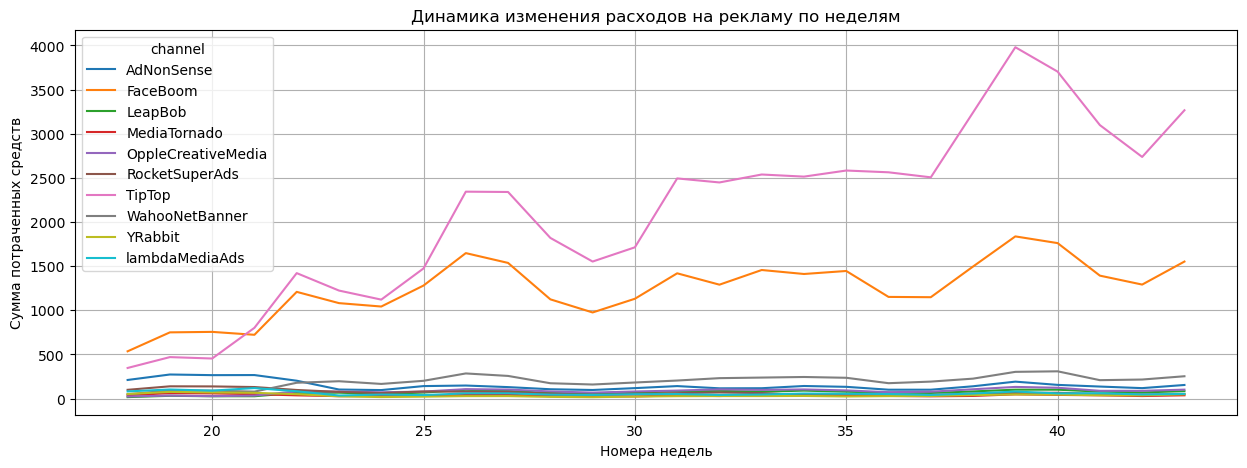

In [85]:
costs_weekly.plot(
    grid=True,  # добавляем сетку
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Номера недель')  # название оси X
plt.ylabel('Сумма потраченных средств') # название оси Y
plt.title('Динамика изменения расходов на рекламу по неделям')  # название графика
plt.show()

Аналогично соберем расходы по месяцам

In [87]:
costs_monthly = costs.pivot_table(index='month', columns='channel',values='costs',aggfunc='sum')
costs_monthly

channel  AdNonSense  FaceBoom  LeapBob  MediaTornado  OppleCreativeMedia  \
month                                                                      
5           1169.70    3524.4   140.28        238.56              169.75   
6            538.65    5501.1   314.58        138.00              370.00   
7            504.00    5294.3   313.53        138.48              366.50   
8            579.60    6274.4   369.81        154.56              439.25   
9            581.70    6114.9   343.98        144.72              427.75   
10           537.60    5736.5   315.42        140.16              378.00   

channel  RocketSuperAds   TipTop  WahooNetBanner  YRabbit  lambdaMediaAds  
month                                                                      
5               577.980   2981.0           418.8   299.70           458.4  
6               325.715   6675.6           921.0   106.20           199.2  
7               252.070   8410.2           851.4    97.38           219.2  
8               253.110  11202.0          1040.4   124.74           220.0  
9               218.400  13232.5           977.4   152.79           247.2  
10              205.725  12250.0           942.0   163.41           213.6

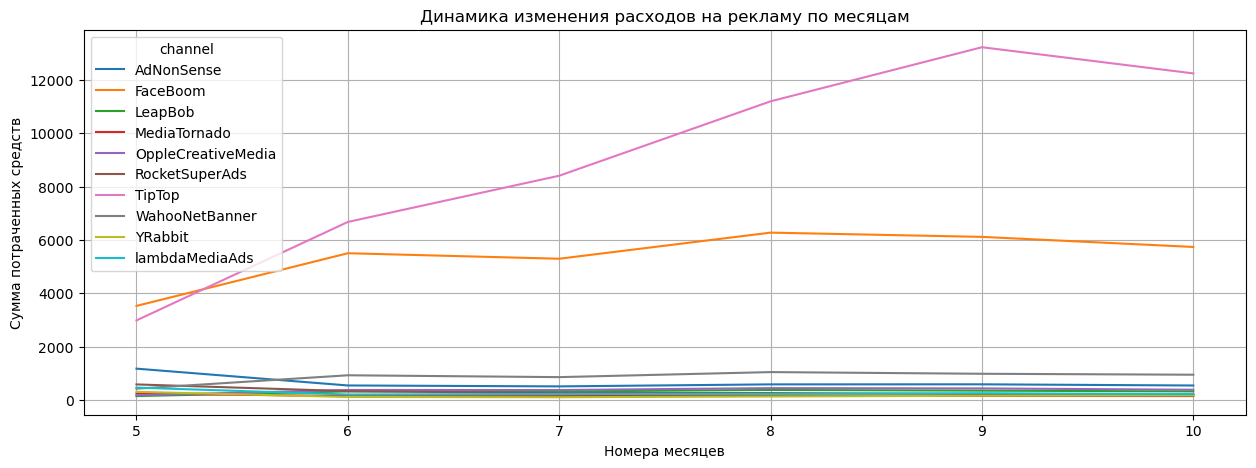

In [88]:
costs_monthly.plot(
    grid=True,  # добавляем сетку
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Номера месяцев')  # название оси X
plt.ylabel('Сумма потраченных средств') # название оси Y
plt.title('Динамика изменения расходов на рекламу по месяцам')  # название графика
plt.show()

Мы видим подтверждение того, что основной рекламный бюджет уходил на два сервиса TipTop и FaceBoom, причем на рекламу в TipTop уходило больше всего средств, доходя до 13 000 в месяц, в то время как на остальные уходило не больше 1000. 

При этом реклама на TipTop приводит в полтора раза меньше пользователей, чем реклама на FaceBoom, как и платящих пользователей меньше почти в два раза.

Посмотрим какова стоимость привлечения клиента на каждой платформе

In [91]:
display(round(profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost',ascending=False),2))

acquisition_cost
channel                             
TipTop                          2.80
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
YRabbit                         0.22
MediaTornado                    0.22
LeapBob                         0.21
organic                         0.00

Как видим, средняя стоимость привлечения одного пользователя на сервисе TipTop в 2.5 раза больше, чем на сервисе FaceBoom, но пользователей привлекает в полтора раза меньше, среди которых плятящих в два раза меньше, чем на сервисе FaceBoom.

Возможно, выбор основного рекламного сервиса был неудачен и стоит пересмотреть вложения в рекламу, отдав предпочтение другому сервису.

### Окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 

- Проанализируем  окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Посмотрим:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [95]:
# установим момент и горизонт анализа данных.
observation_date = datetime(2019,11,1).date()
horizon_days = 14

Посмотрим на окупаемость рекламы. Для этого построим графики LTV и ROI.

In [97]:
profiles_filtered = profiles[profiles['channel'] != 'organic']

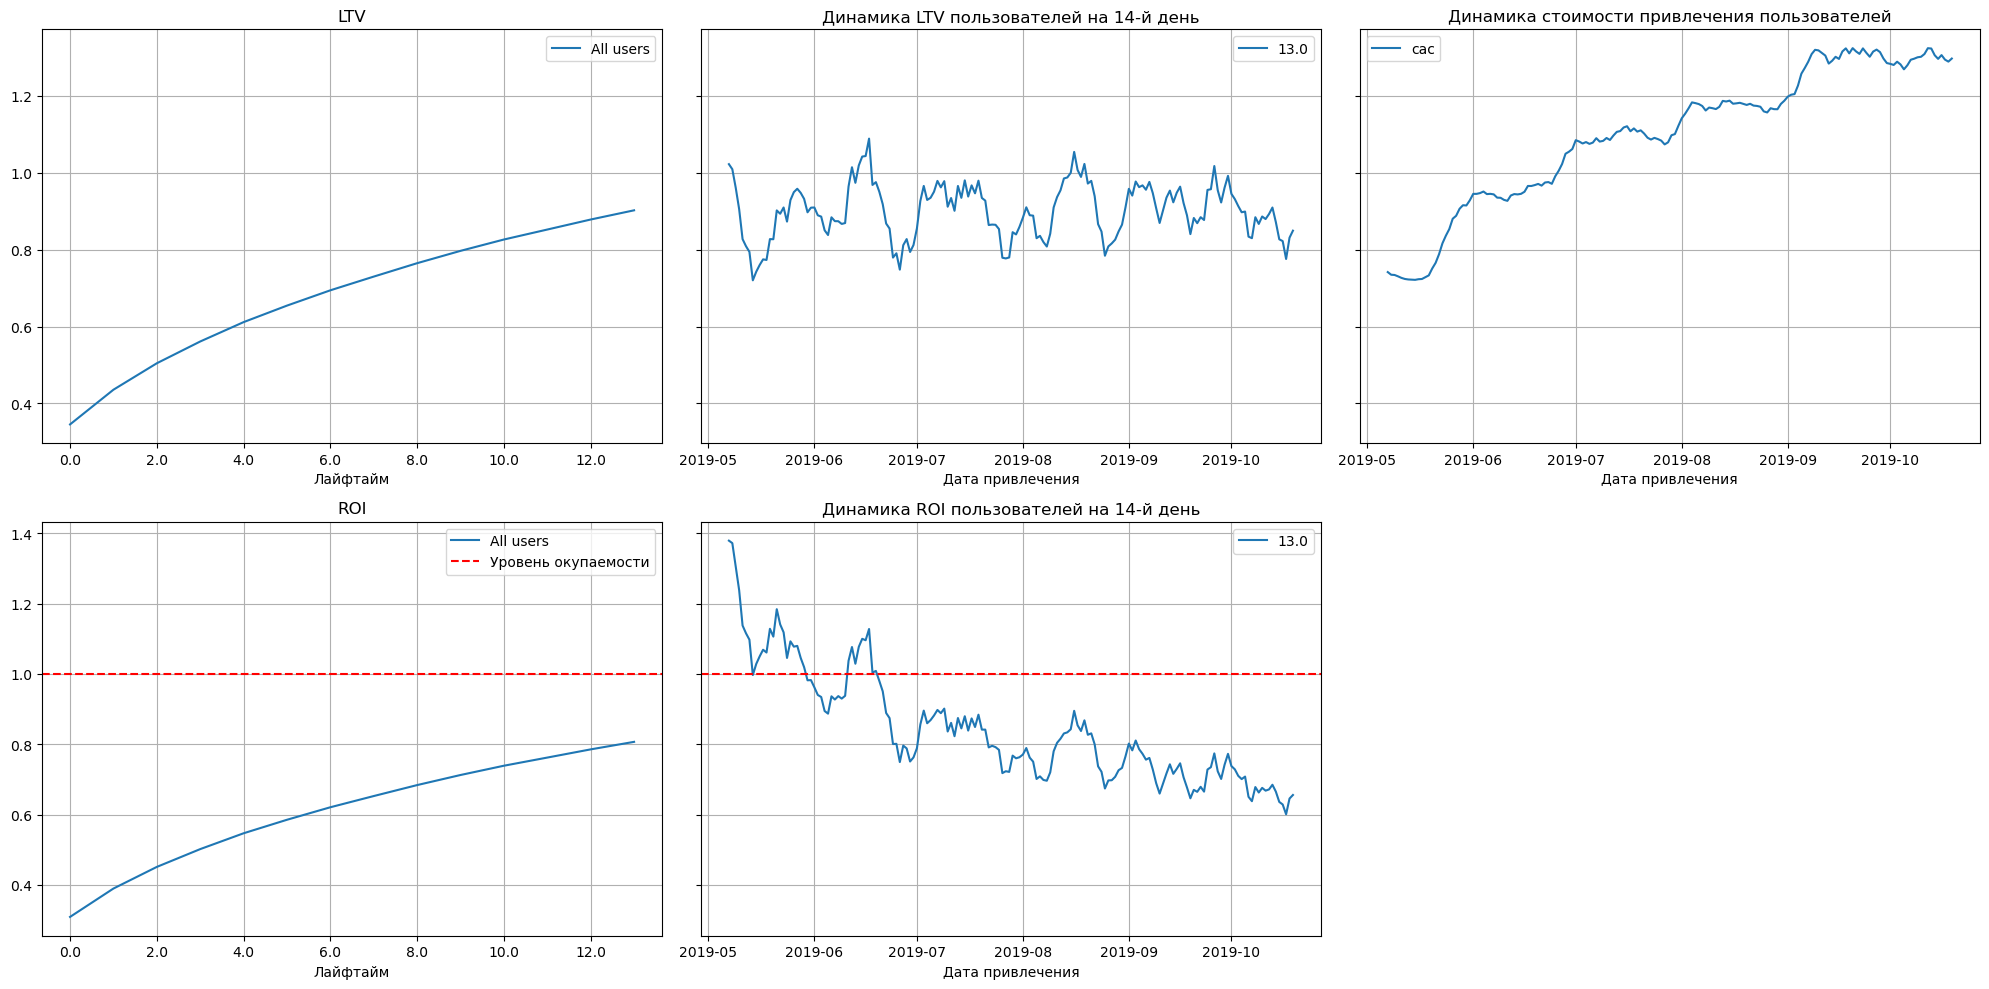

In [98]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков видно, что реклама не окупается, к концу второй недели ROI  достигает только 80%; лучше всего окупались пользователи, привлеченные в мае 2019 года, при этом затраты на рекламу резко возрасли в конце мая и продолжали расти до конца октября. LTV пользователей не превышает CAC, что говорит нам об убытках компании.

Посмотрим как ведут себя конверсия и удержание пользователей.

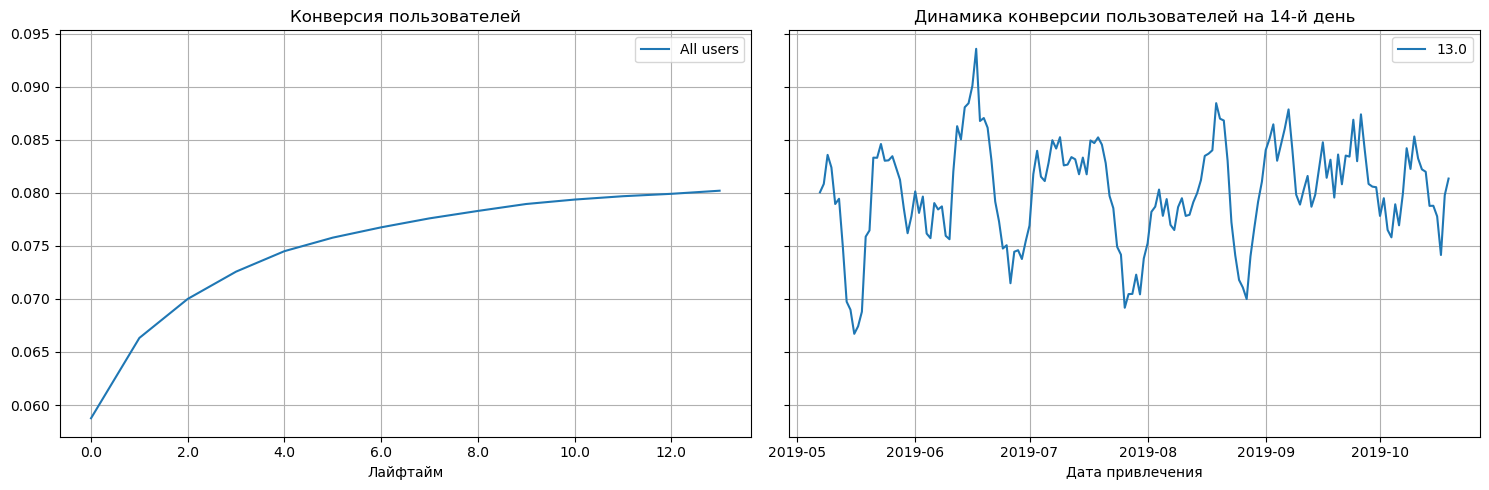

In [100]:
# смотрим конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей хорошая, к концу второй недели достигает 8%, но при этом она нестабильна по времени привлечения. Мы видим просадку в динамике конверсии в первой половине мая, конце июня, июля и августа.

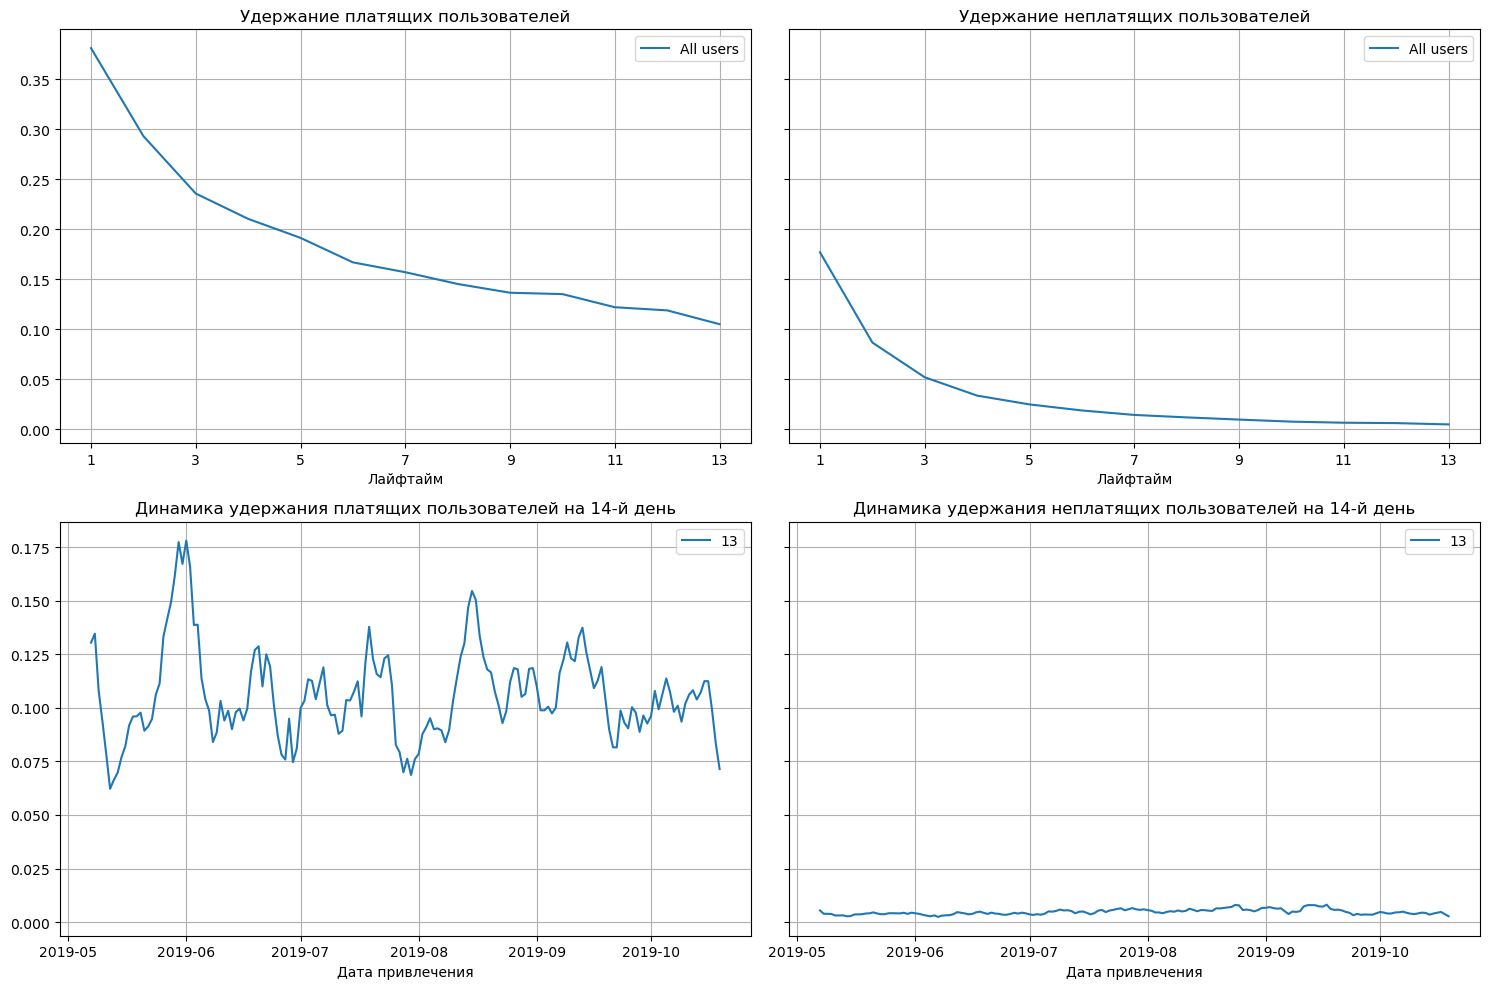

In [102]:
# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В динамике удержания платящих пользователей также видно сильное колебание, при этом лучше всего удерживались пользователи, привлеченные в конце мая - начале июня, в начале мая также как в графике конверсии виден провал, что говорит, что пользователей не устраивало приложение.

Чтобы понять причины провала рекламы, пройдем по всем характеристикам пользователей - страна, канал привлечения и устройство первого входа.

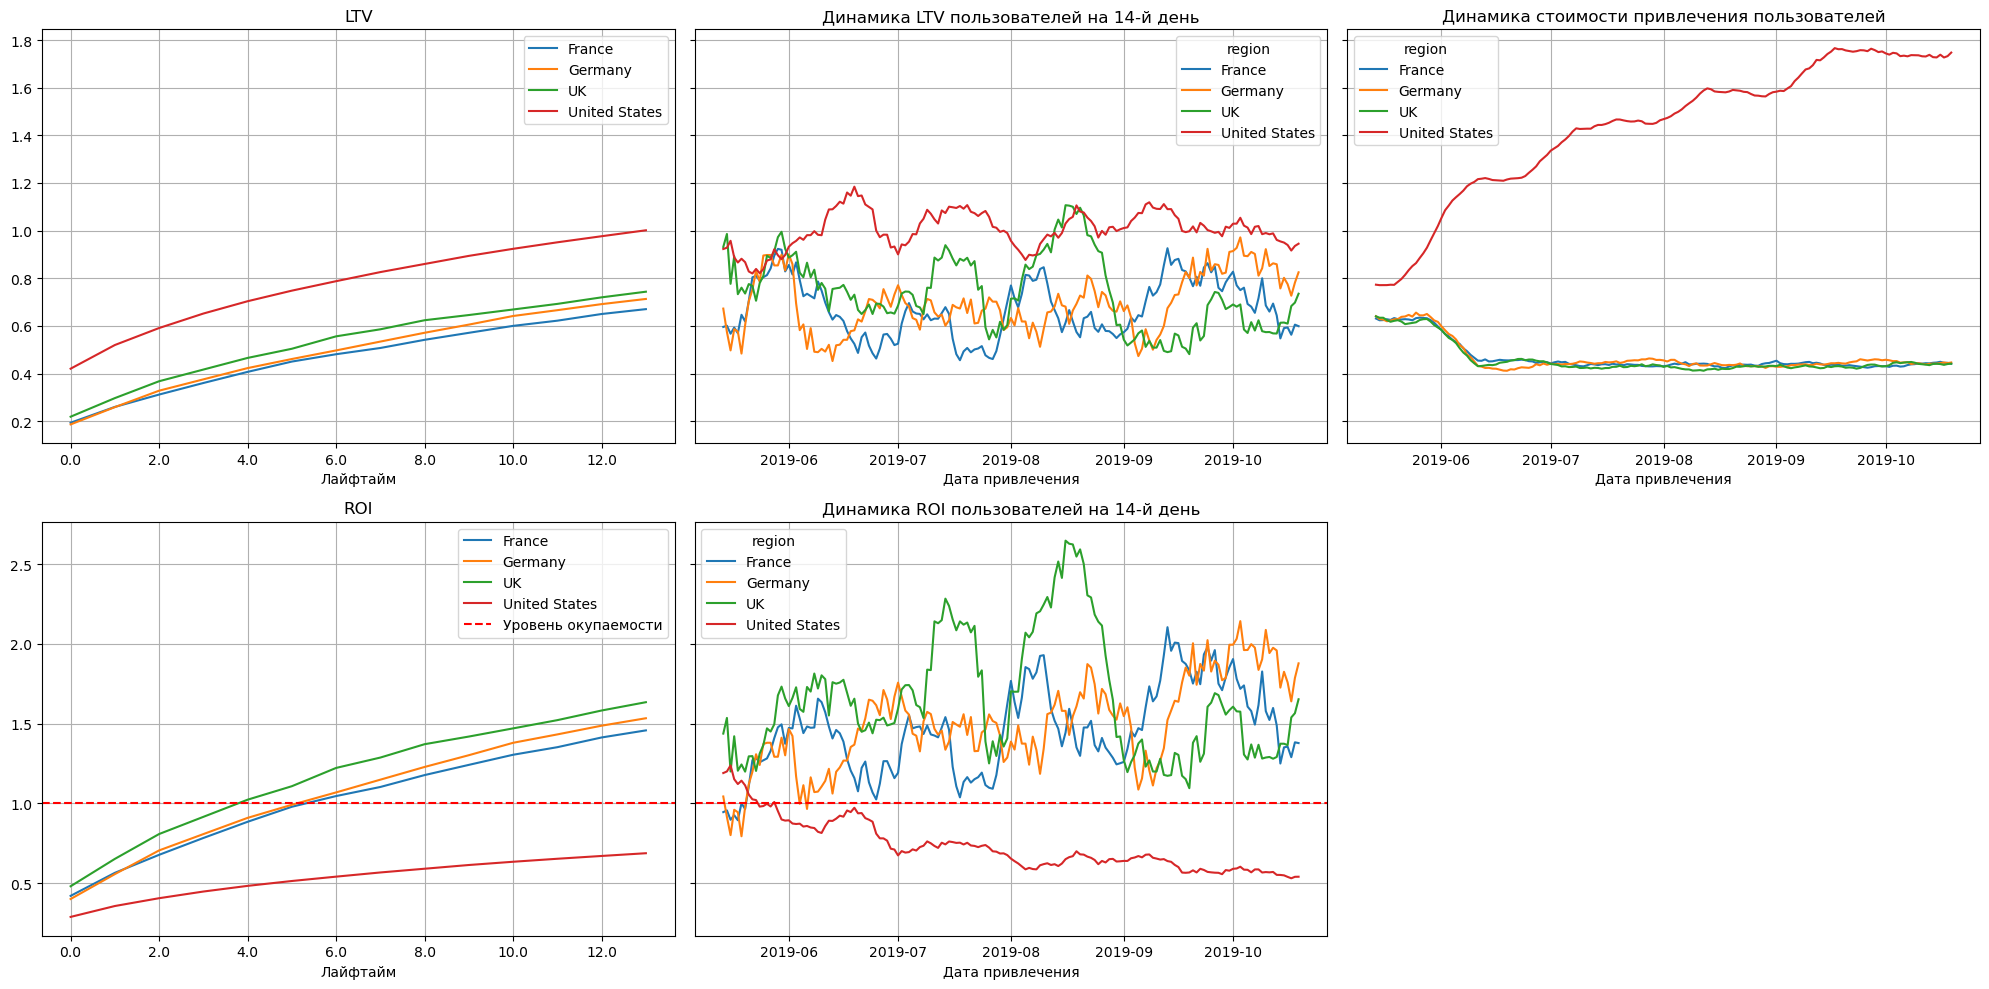

In [104]:
# посмотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Как мы видим, что больше всего средств тратилось на рекламу в США, мы видим резкий скачок в динамике стоимости привлечения пользователей,в то время как стоимость привлечения пользователей по другим странам даже снизилась и осталась на этом уровне.  Не смотря на большие вложения, именно в США реклама не окупилась, принося убытки уже с конца мая. Однако, самыми высокооплачиваемыми пользователями являются пользователи из США. LTV этих пользователей стабильно высок в динамике.
Лучше всего окупается реклама в Великобритании. 
Возможно, стоит изменить рекламу в США.

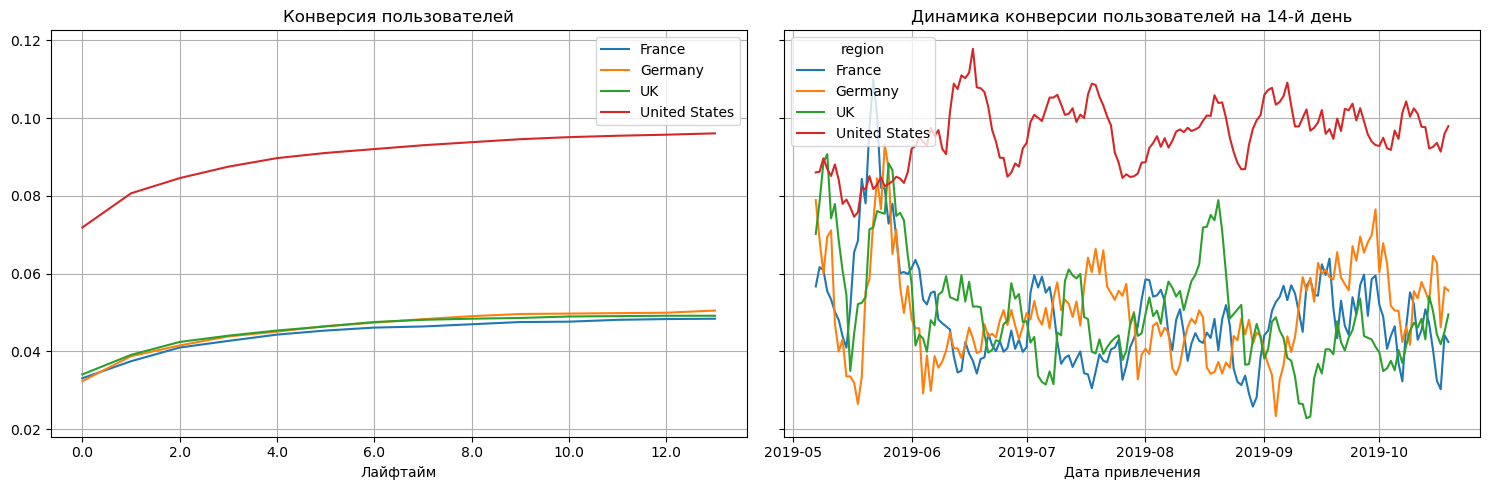

In [106]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Как видно из графиков пользователи в США конвертируются очень хорошо, практически в два раза лучше, чем пользователи в других странах, что говорит нам о ценности таких пользователей. Посмотрим, как удерживаются пользователи по странам. 

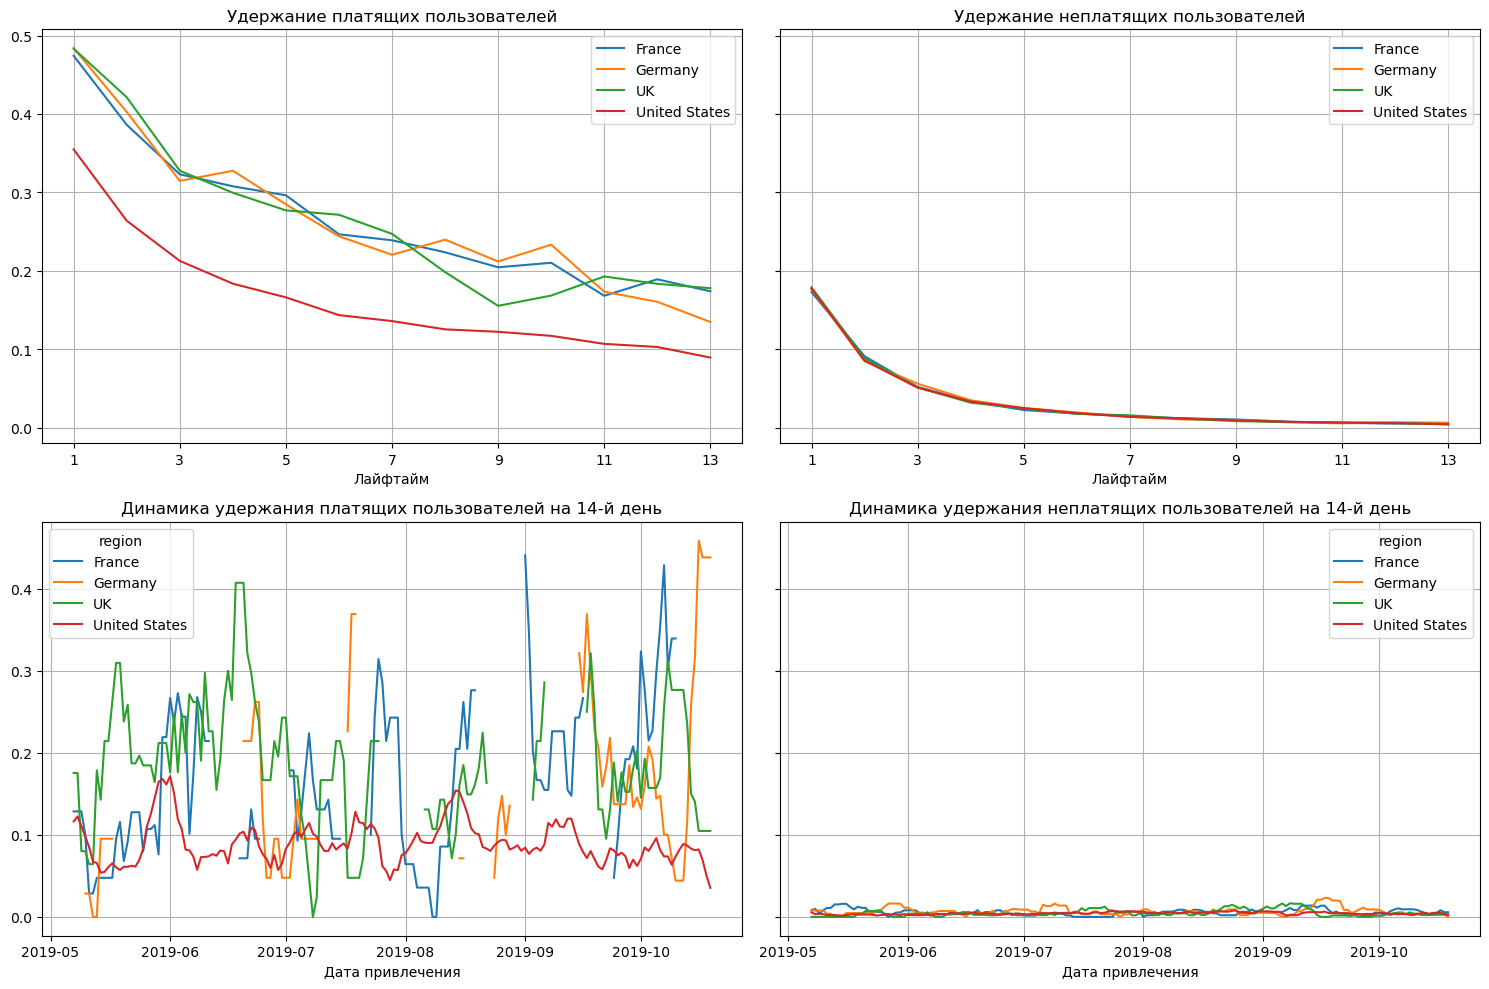

In [108]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 


А вот тут видно, что скорее всего есть проблема с удержанием платящих пользователей именно из США, причем RR для таких пользователей стабильно низок, значит, проблема возникла сразу же и в течение всего времени не была выявлена и решена. Динамика удержания неплатящих пользователей не зависит от страны, значит, есть проблема с оплатой.

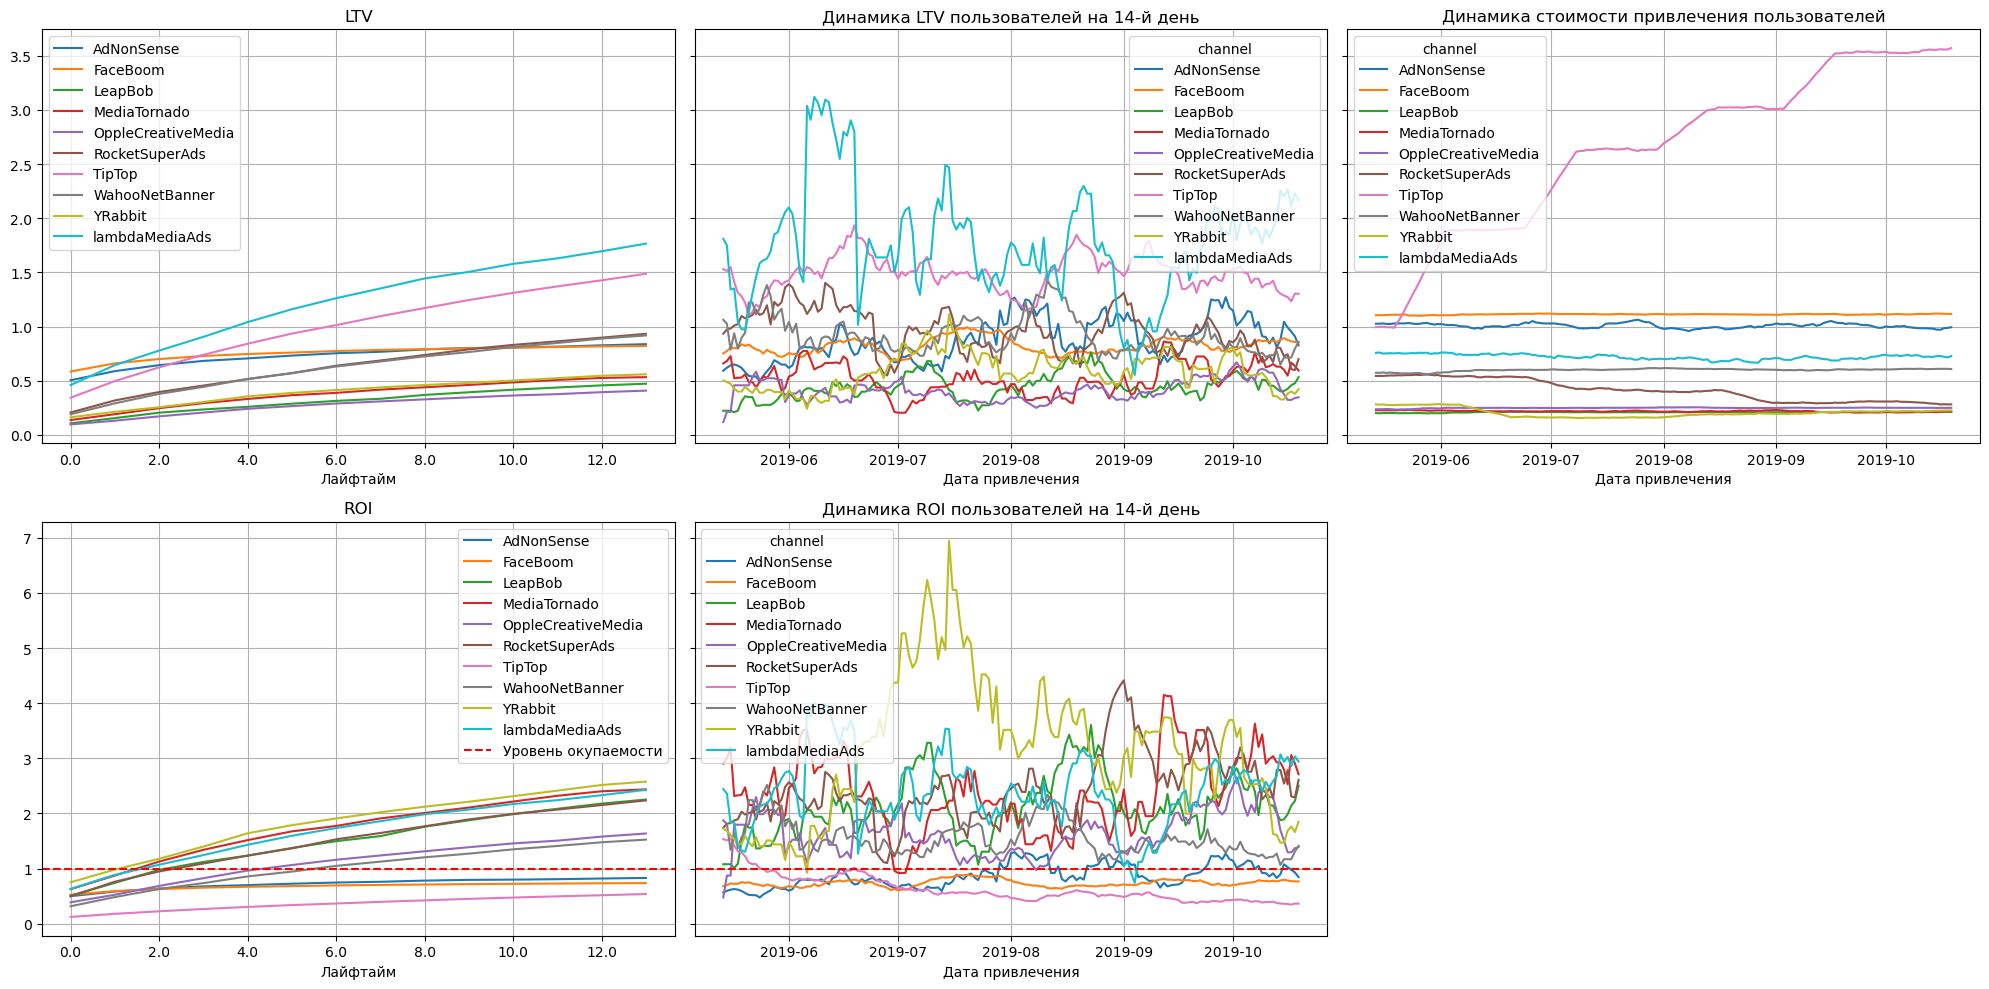

In [110]:
# проверим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Если смотреть по каналам привлечения пользователей, то можно сказать, что реклама на сервисах TipTop, FaceBoom и AdNonSence не окупается, хотя именно на них самые высокие стоимости привлечения пользователей. Ставка на рекламу на сервисе TipTop себя не оправдала. Лучше всего окупалась реклама на YRabbit,  MediaTornado и LambdaMediaAds, пользователи, пришедшие с последнего источника имеют лучший LTV.

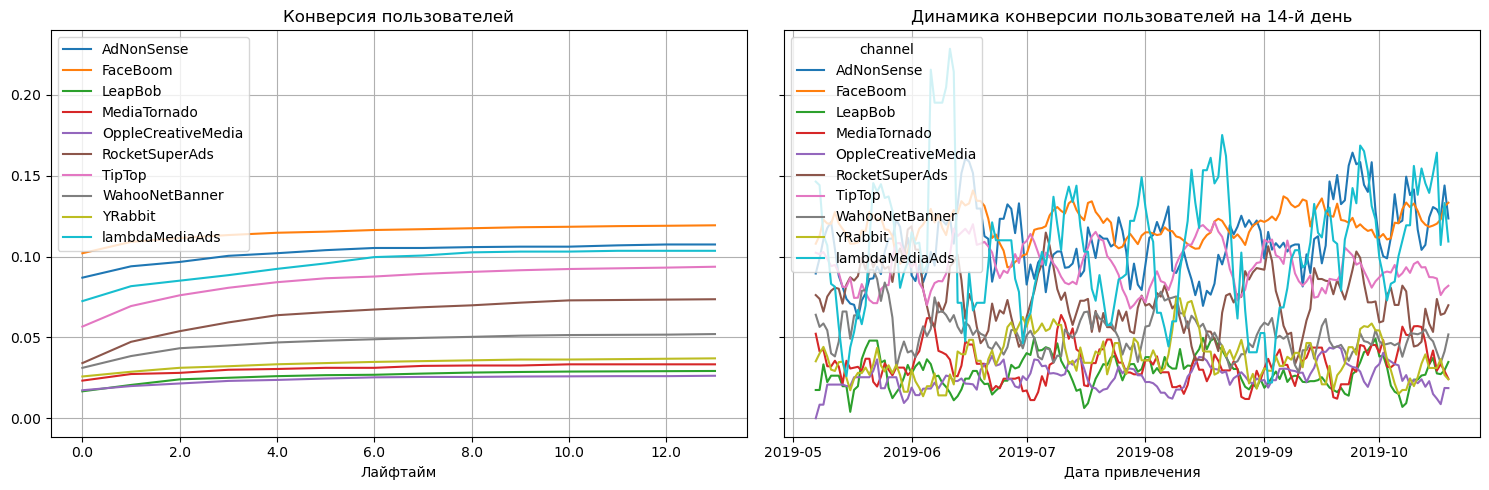

In [112]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Как видно из графиков, конверсия пользователей наибольшая по следующим источникам привлечения: FaceBoom, AdNonSense, LambdaMediaAds и TipTop. Посмотрим, что происходит с удержанием пользователей.

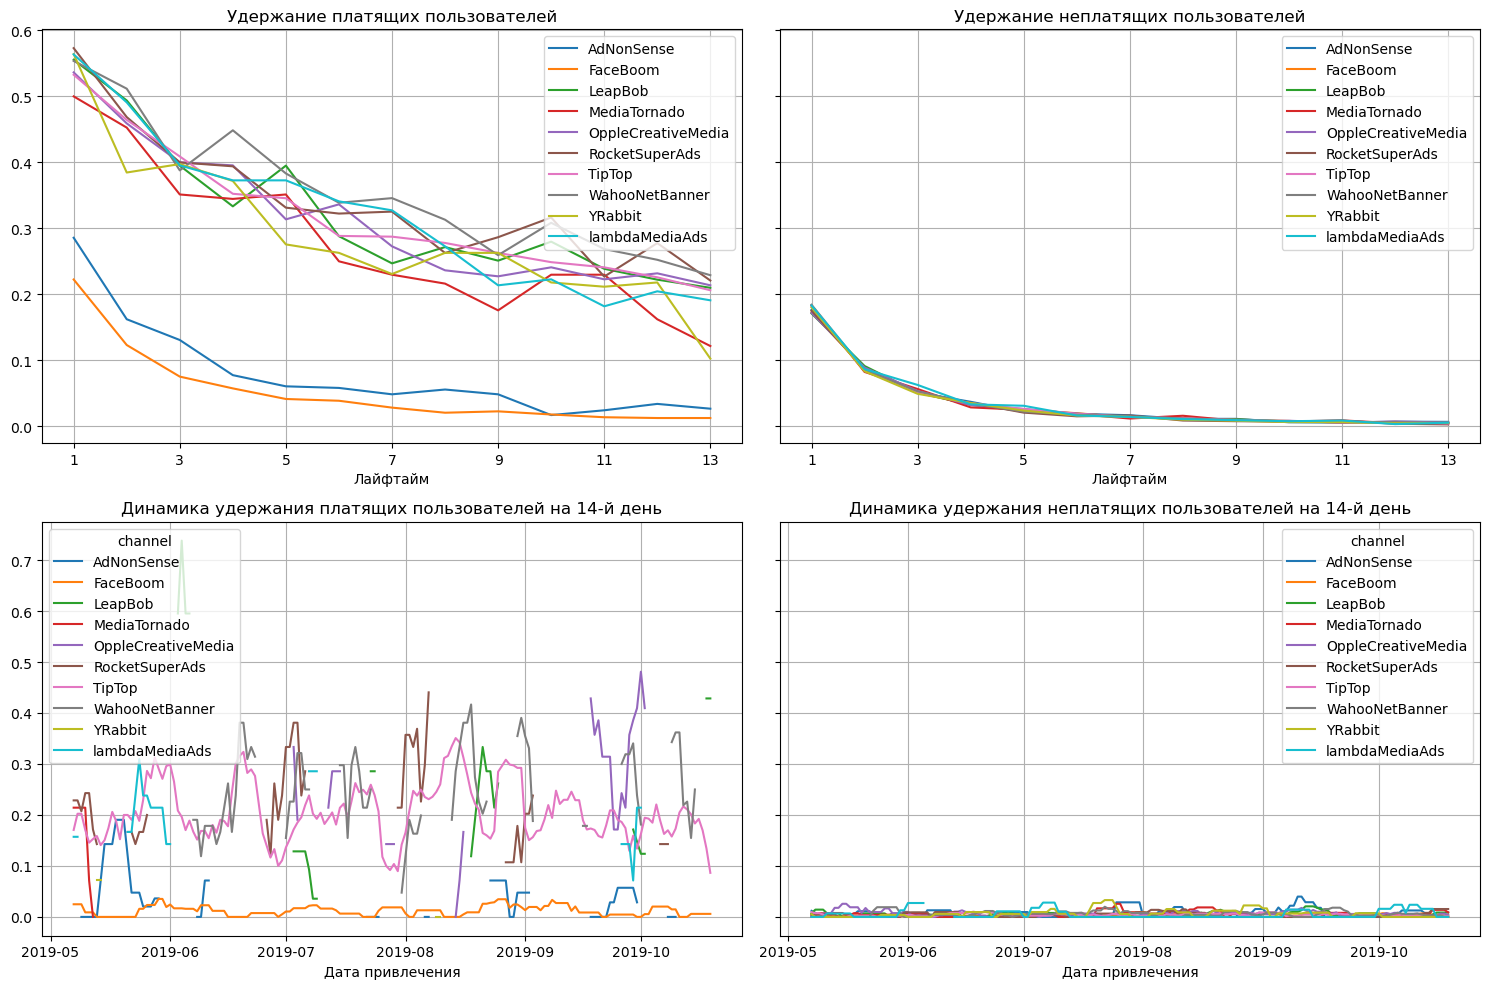

In [114]:
# смотрим удержание с разбивкой по каналам привлечения.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Здесь мы видим, что удержание пользователей, перешедших по рекламе на сервисе FaceBoom, является наихудшим, что однако не сказывается на неплатящих пользователях. 

У пользователей, перешедших с сервиса TipTop, хорошая конверсия, высокий LTV и коэффициент удержания, но слишком большие вложения в рекламу на этом сервисе привели к тому, что реклама не окупается. Стои пересмотреть бюджет рекламных компаний и перераспределить средства на другие источники. 

Также необходимо проверить нет ли проблем с оплатой у пользователей, пришедших с FaceBoom, так как коэффициент конверсии у них наивысший, а коэффициент удержания наихудший. Также стоит проверить саму рекламу, так как она не окупается и LTV этих пользователей невысок, возможно, стоит пересмотреть тактику рекламы на этом сервисе.

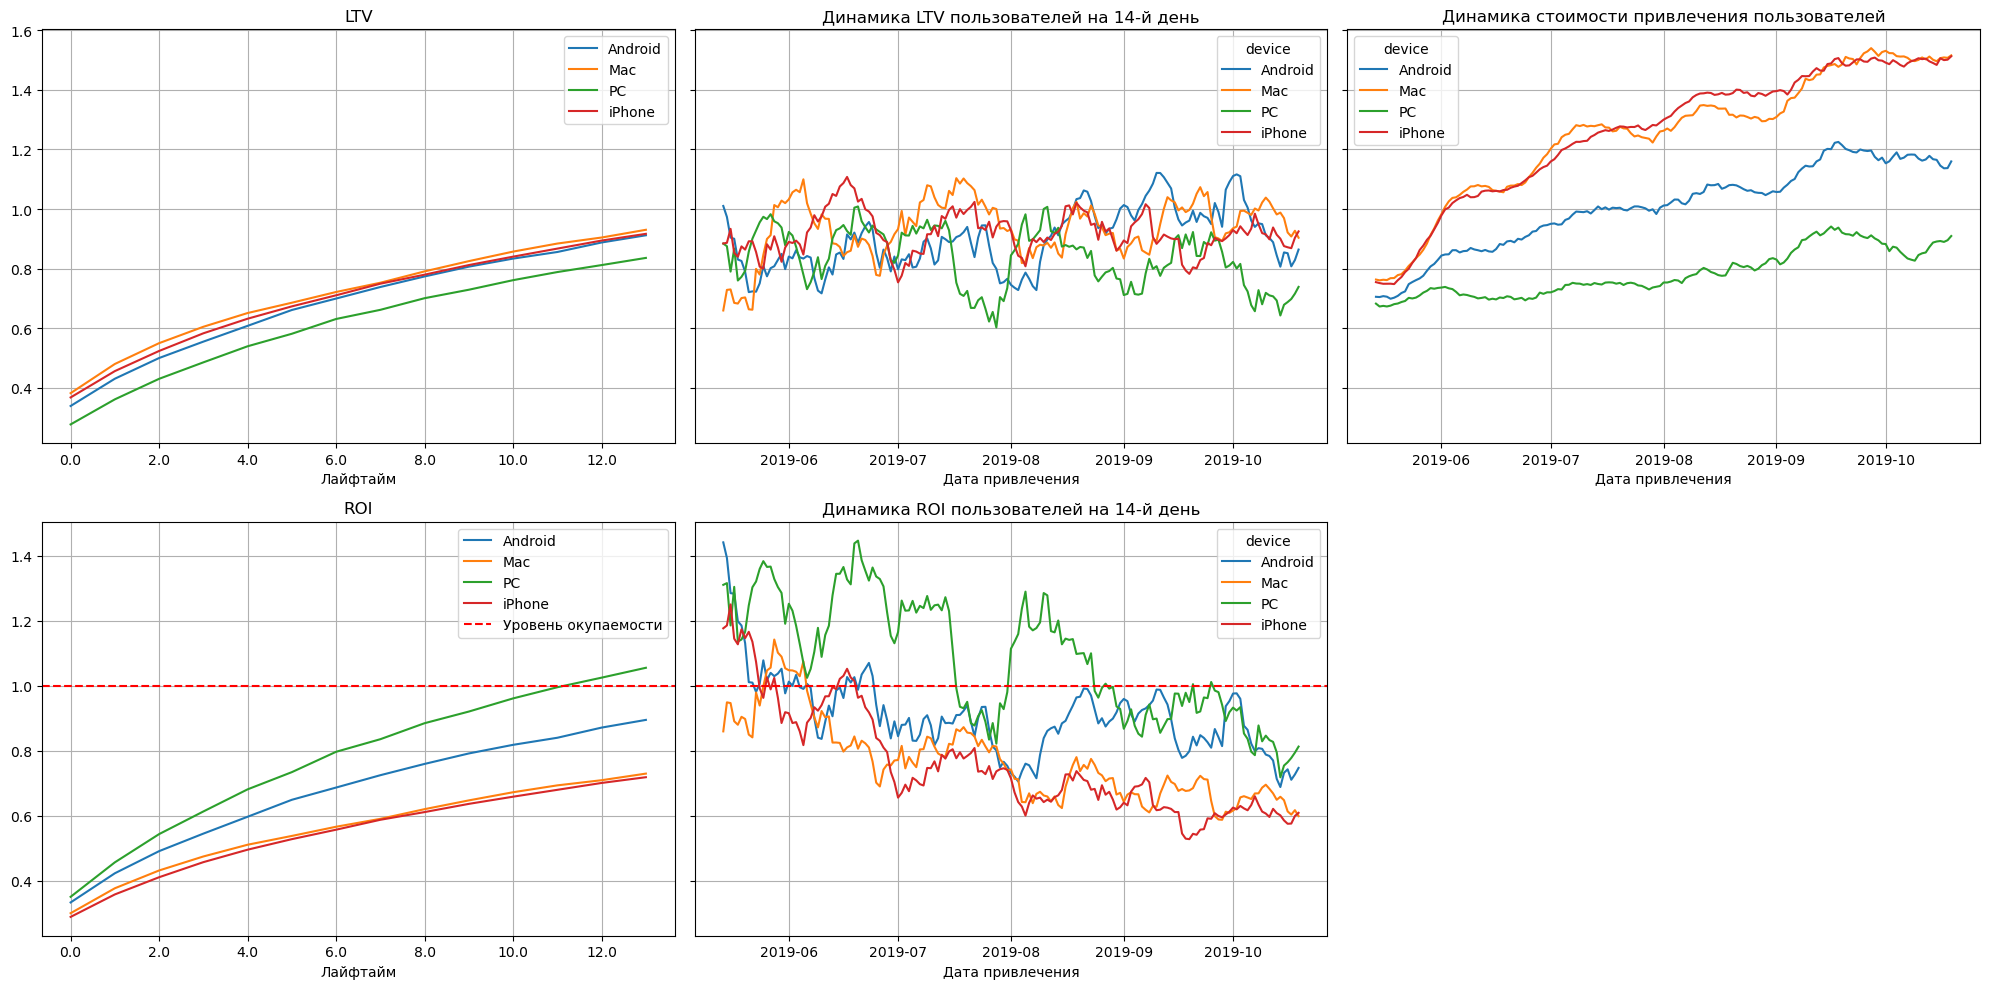

In [116]:
# проверим окупаемость с разбивкой по устройства первого входа
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видно, что при реклама окупилась только у пользователей компьютеров, возможно, приложение максимально удобно сделано именно под компьютер, но не под мобильную версию, а для iPhone и Mac существует аналогичное приложение, сделанное более удобно. Также, видимо, показ рекламы на iPhone и Mac стоит дороже.

LTV практически не зависит от типа устройства пользователя. Посмотрим, возможно, конверсия и удержание как-то зависят от этого.

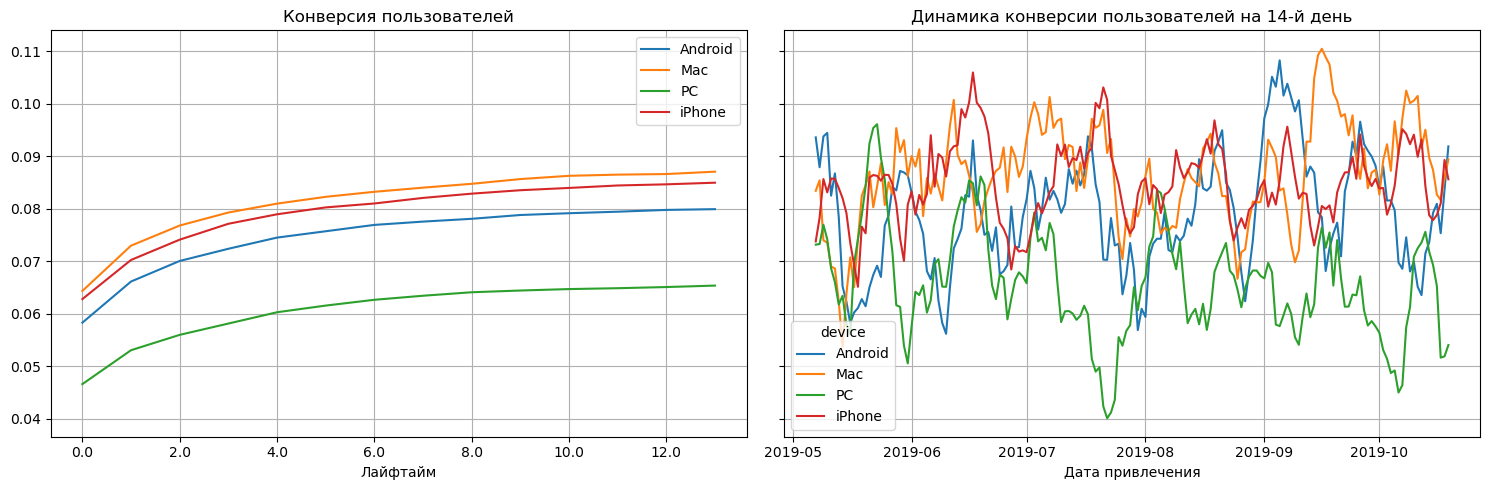

In [118]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам видно, что пользователи iPhone, Mac и Android конвертируются хорошо и довольно стабильно.


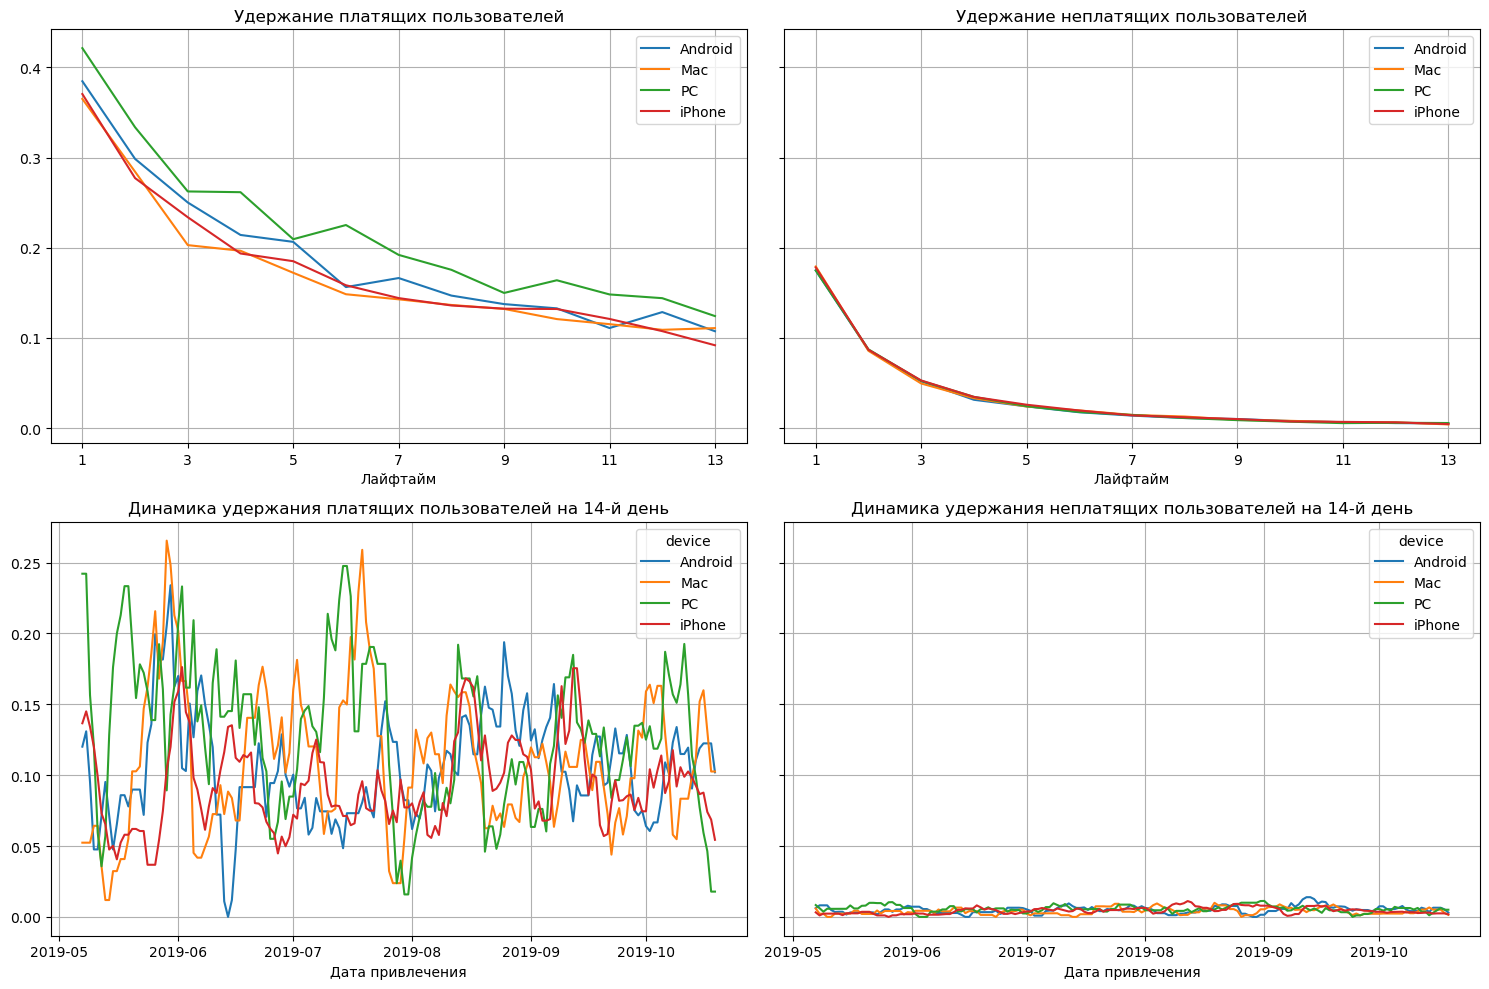

In [120]:
# смотрим удержание с разбивкой по устройствам первого входа.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Как видим коэффициет удержания также практически не зависит от типа устройств. Следовательно, проблема в окупаемости рекламы заключается не в типе устройства пользователя.

In [122]:
profiles_USA = profiles_filtered[profiles_filtered['region'] == 'United States']
profiles_USA.head()

user_id            first_ts       channel  device         region  \
0    599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
4  31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
8  58263264 2019-05-11 19:18:43      FaceBoom  iPhone  United States   
9  59835779 2019-05-11 21:13:47  MediaTornado  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
4  2019-10-02 2019-10-01  False          0.230769  
8  2019-05-11 2019-05-01  False          1.128205  
9  2019-05-11 2019-05-01  False          0.250435

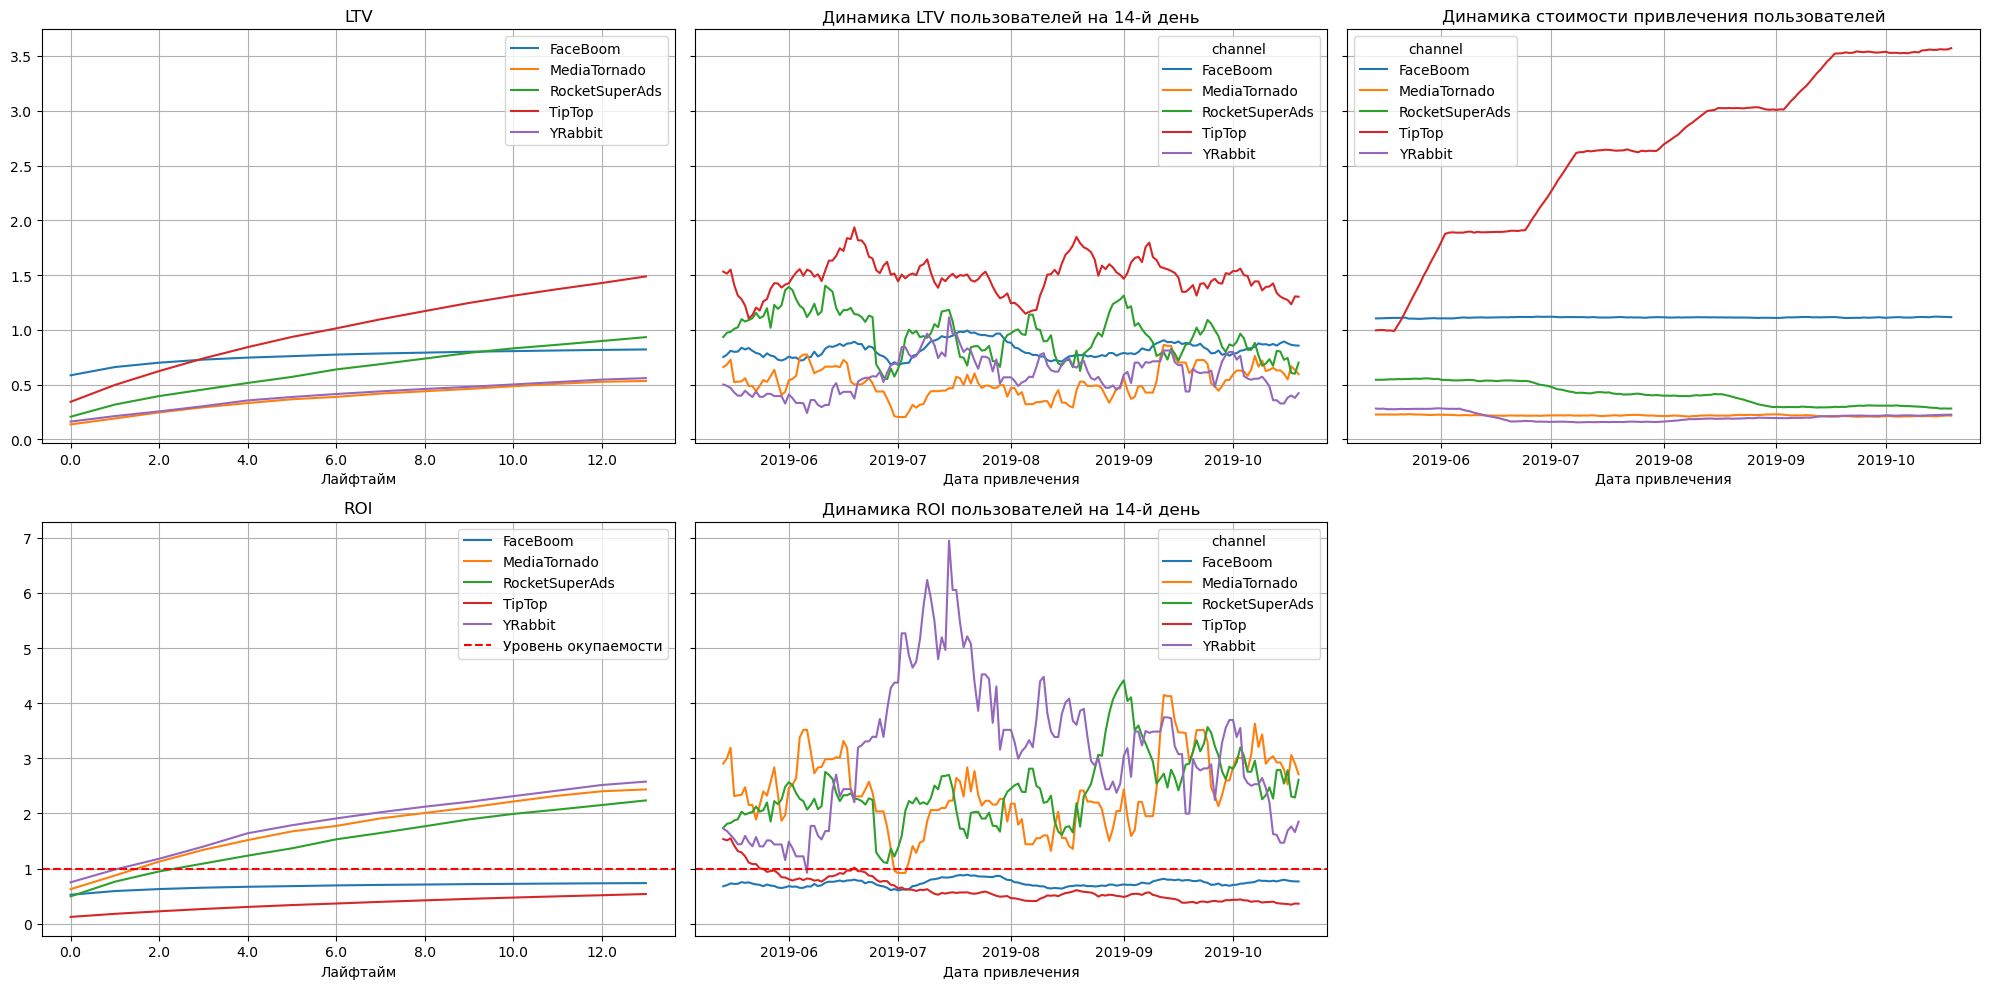

In [123]:
# проверим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Как видно из графиков, в США реклама велась на пяти сервисах, при этом основная ставка была на сервис TipTop, который приводил самых "ценных" пользователей, LTV у этих пользователей наибольший. Однако CAC гораздо выше LTV, и в результате видно, что реклама на этом сервисе не окупается с самого начала.

На сервисе FaceBoom рекламный бюджет был стабилен, но все равно реклама не окупается, так как LTV стабильно низок.

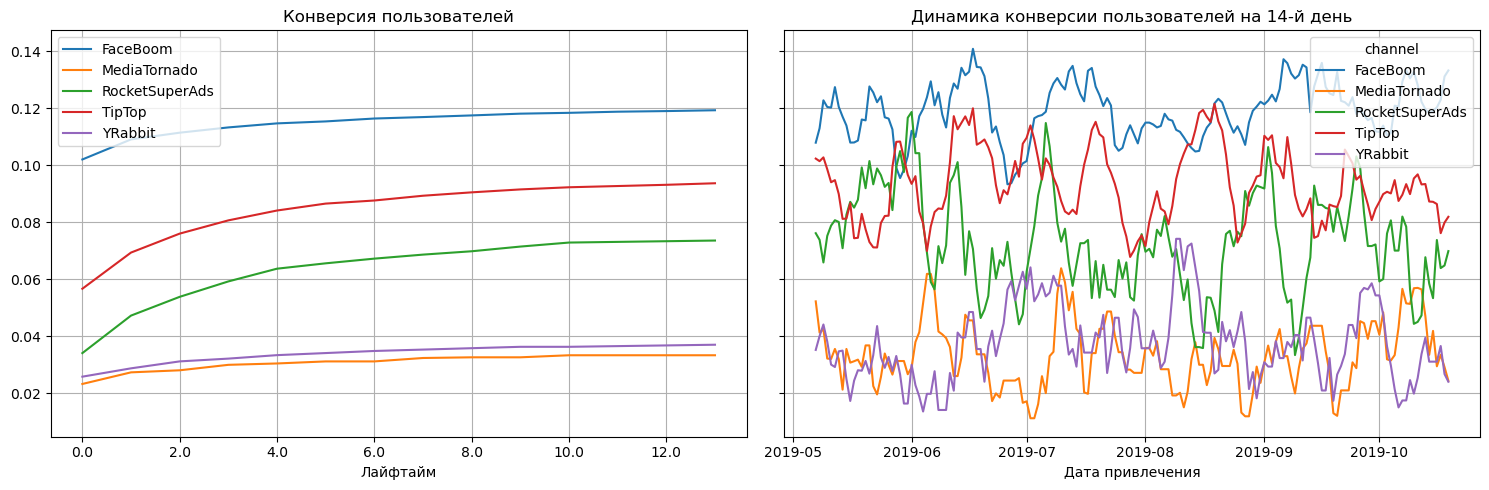

In [125]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

На сервисе FaceBoom самая высокая конверсия 12%, посмотрим как удерживаются пользователи, пришедшие с разных каналов.

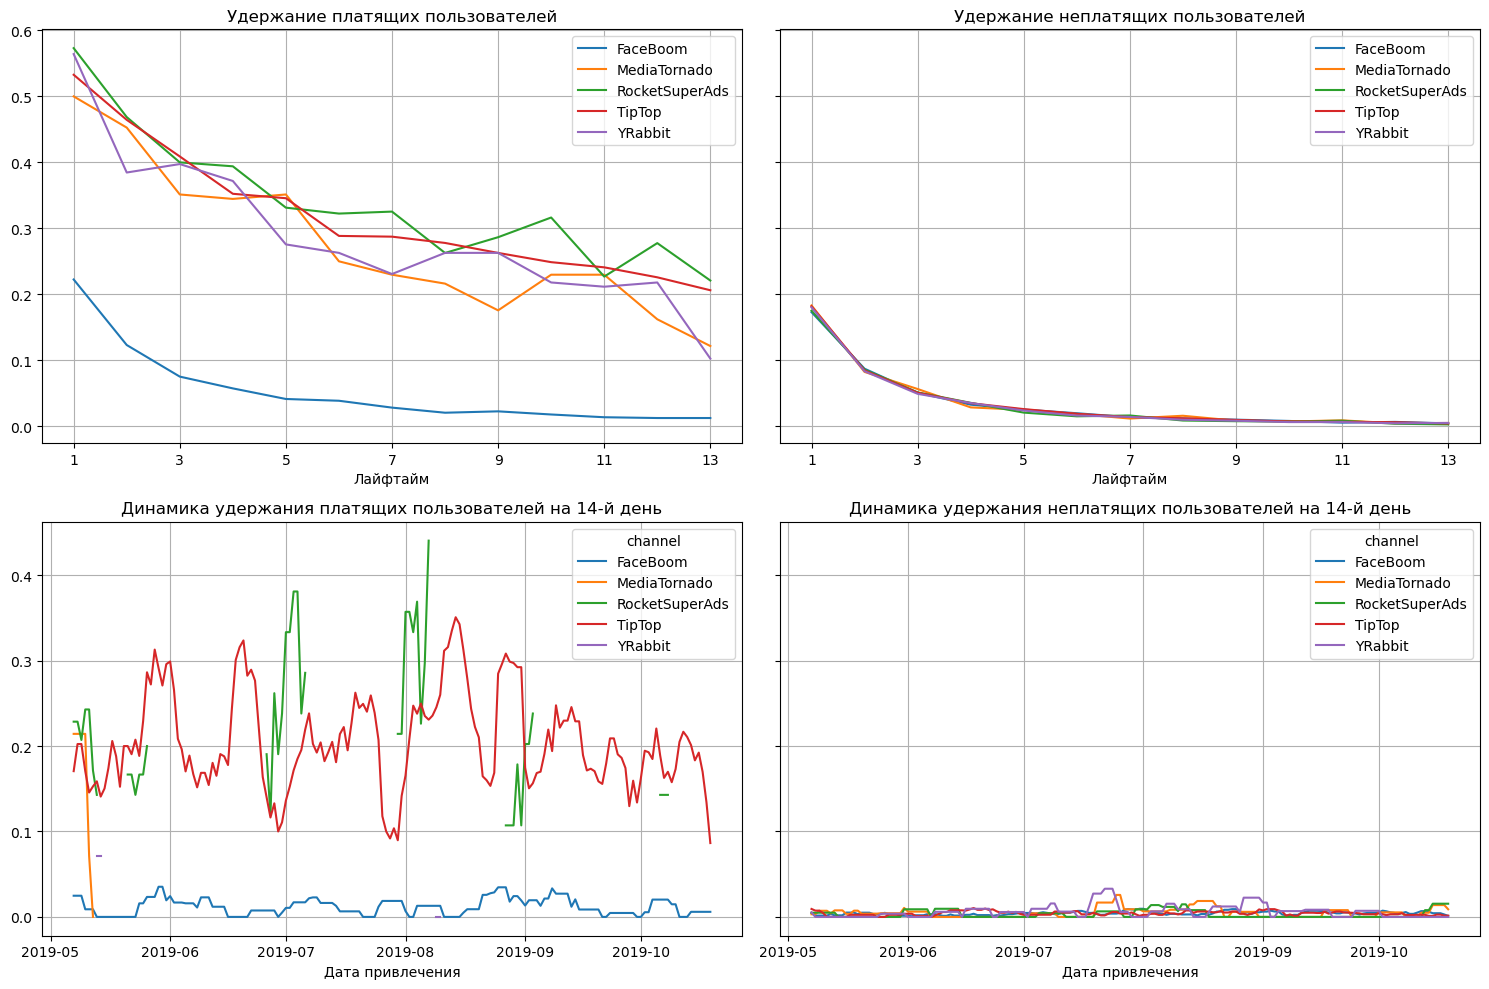

In [127]:
# смотрим удержание с разбивкой по устройствам первого входа.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_USA, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

На графиках видно, что удержание пользователей, пришедших с FaceBoom, очень низкое, практически 0%, видимо есть технические проблемы с оплатой.
У пользователей, пришедших с других рекламных каналов, коэффициент удержания гораздо выше и практически одинаков.

Таким образом, реклама в США не окупается по самым высокооплачиваемям рекламным каналам, в случае с сервисом TipTop стоит уменьшить расходы на рекламу, а с сервисом FaceBoom - проверить технические аспекты оплаты, так как при самой высокой конверсии мы имеем практически нулевое удержание.

Проверим окупаемость рекламы по другим странам.

In [129]:
profiles_europe = profiles_filtered[profiles_filtered['region']!='United States']
profiles_europe.head()

user_id            first_ts         channel   device   region  \
3    22593348 2019-08-22 21:35:48      AdNonSense       PC  Germany   
7    46006712 2019-06-30 03:46:29      AdNonSense  Android   France   
17   93828625 2019-07-24 05:56:22         LeapBob   iPhone  Germany   
24  138399008 2019-07-20 16:59:16  WahooNetBanner       PC       UK   
42  267553828 2019-09-21 12:17:42  WahooNetBanner       PC   France   

            dt      month  payer  acquisition_cost  
3   2019-08-22 2019-08-01  False          0.988235  
7   2019-06-30 2019-06-01   True          1.008000  
17  2019-07-24 2019-07-01  False          0.204324  
24  2019-07-20 2019-07-01  False          0.635294  
42  2019-09-21 2019-09-01  False          0.591304

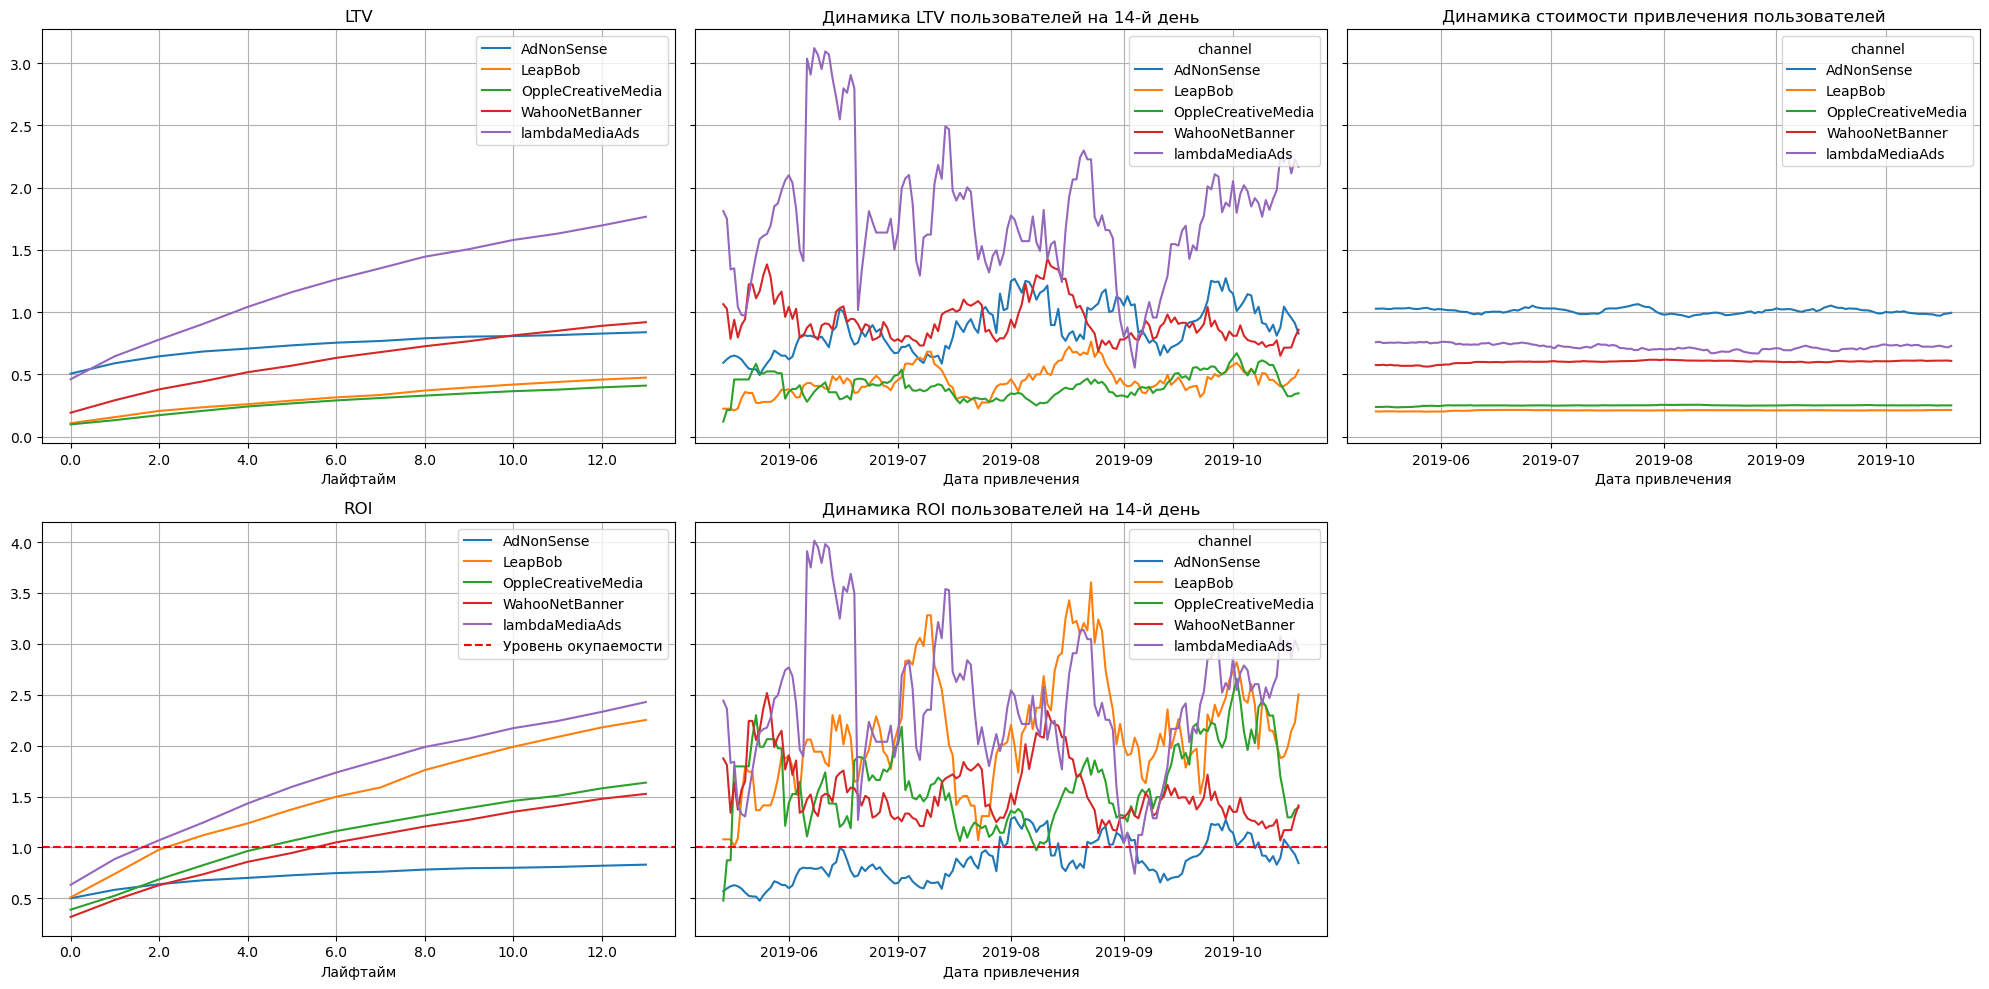

In [130]:
# проверим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Как видим, для стран европы были выбраны другие каналы для рекламы, бюджет рекламы на каждом из каналов был стабилен, но самым дорогим каналом привлечения является AdNonSense. Реклама именно на этом канале не приносит прибыли, а наоборот не окупается. LTV пользователей, пришедших по рекламе с LambdaMediaAds, является самым высоким и приносит максимальную окупаемость рекламы.

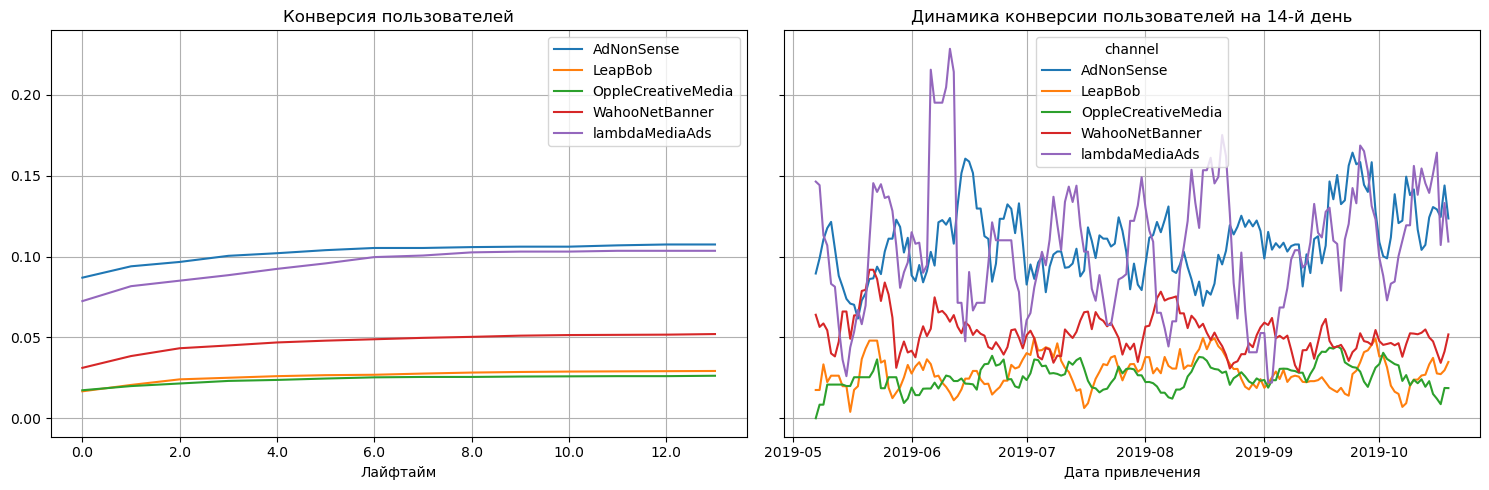

In [132]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей наибольшая по LambdaMediaAds и AdNonSense, почти 11%, и она стабильна.

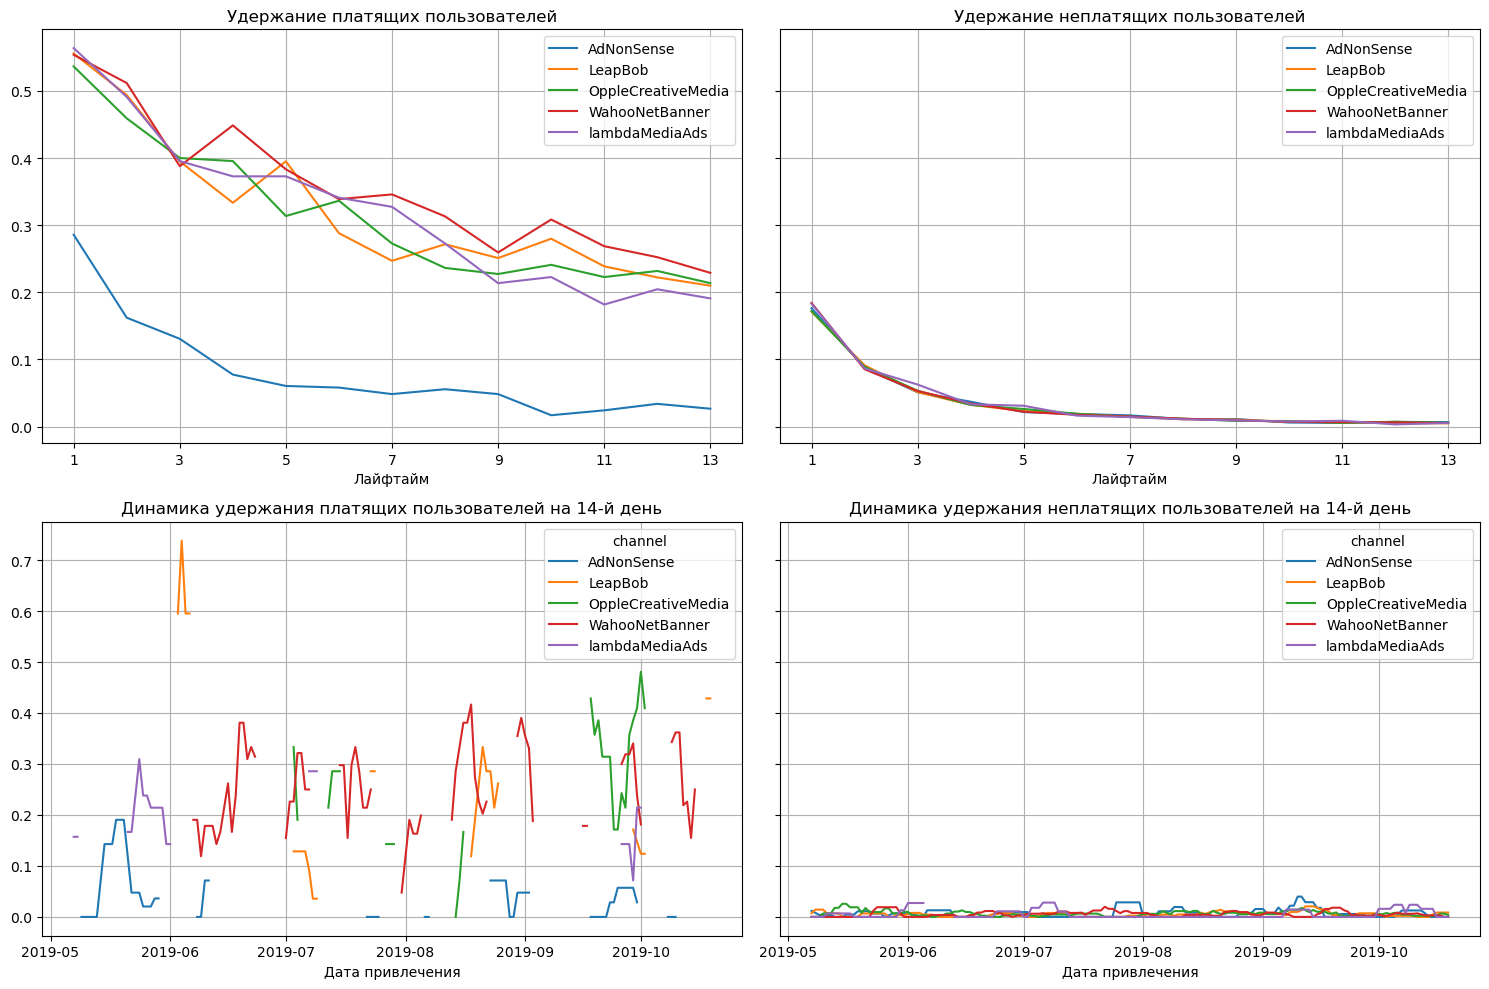

In [134]:
# смотрим удержание с разбивкой по устройствам первого входа.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_europe, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Как и в предыдущих случаях, мы видим, что коэффициент удержания для одного канала практически нулевой. Это AdNonSense. Опять же, скорее всего, возникают какие-либо технические проблемы с оплатой, так как неплатящие пользователи удерживаются одинаково.

Таким образом, можно сказать, что стоит проверить нет ли каких-либо технических проблем с оплатой у пользователей, перешедших по рекламе с сервиса AdNonSense. И, возможно, можно немного увеличить бюджет рекламы на сервисе LambdaMediaSense.

### Выводы

У нас были данные о визитах, заказах и стоимости рекламы для приложения ProcrastinatePro+ в период с 1 мая по 27 октября 2019 года. Несмотря на огромные вложения в рекламу, приложение несет убыдки. Наша задача состояла в изучении данных и выяснить возможные причины убыточности.


В ходе анализа мы получили данные о 150008 различных пользователях, проживающих в США, Великобритании, Франции и Германии. Большая часть пользователей (100002 чел) проживают в США, при этом доля платящих пользователей составляет почти 7%. 
большинство пользователей находили приложение в органическом поиске, однако доля платящих составляет только 2%. Второе место по количеству привлеченных пользователей принадлежит сервису FaceBoom (доля платящих 12.2%), третье - сервису TipTop (доля платящих 9.6%).


На рекламу были заложены большие средства, причем распределены они были неравномерно по каналам привлечения, больше всего средств было направлено на рекламу в сервисе TipTop (больше 51%) и FaceBoom, в совокупности рекламный бюджет этих двух сервисов составлял 82.65% от всех выделенных средств. Как следствие, стоимость привлечения одного пользователя на сервисе TipTop в 2.5 раза превышает аналогичную стоимость на сервисе FaceBoom.

Реклама в общем не окупается, к концу второй недели ROI  достигает только 80%; лучше всего окупались пользователи, привлеченные в мае 2019 года, при этом затраты на рекламу резко возрасли в конце мая и продолжали расти до конца октября. LTV пользователей не превышает CAC, что говорит нам об убытках компании.
 Конверсия пользователей хорошая, при этом она нестабильна по времени привлечения. В динамике удержания платящих пользователей также видно сильное колебание, при этом лучше всего удерживались пользователи, привлеченные в конце мая - начале июня, в начале мая также как в графике конверсии виден провал.


Чтобы понять причины провала рекламы, мы изучили характеристики пользователей - страна, канал привлечения и устройство первого входа.

- тип устройства пользователя

Видно, что при реклама окупилась только у пользователей компьютеров, возможно, приложение максимально удобно сделано именно под компьютер, но не под мобильную версию, а для iPhone и Mac существует аналогичное приложение, сделанное более удобно. Также, видимо, показ рекламы на iPhone и Mac стоит дороже.

LTV практически не зависит от типа устройства пользователя, как и конверсия и  коэффициент удержания. Следовательно, причины провала не зависит от типа устройства пользователя, оно одинаково работает на всех устройствах.

- канал привлечения пользователя

Если смотреть по каналам привлечения пользователей, то можно сказать, что реклама на сервисах TipTop, FaceBoom и AdNonSence не окупается, хотя именно на них самые высокие стоимости привлечения пользователей. Ставка на рекламу на сервисе TipTop себя не оправдала. Лучше всего окупалась реклама на YRabbit,  MediaTornado и LambdaMediaAds, пользователи, пришедшие с последнего источника имеют лучший LTV.

Здесь мы видим, что удержание пользователей, перешедших по рекламе на сервисе FaceBoom, является наихудшим, что однако не сказывается на неплатящих пользователях. 

У пользователей, перешедших с сервиса TipTop, хорошая конверсия, высокий LTV и коэффициент удержания, но слишком большие вложения в рекламу на этом сервисе привели к тому, что реклама не окупается. Стои пересмотреть бюджет рекламных компаний и перераспределить средства на другие источники. 

Также необходимо проверить нет ли проблем с оплатой у пользователей, пришедших с FaceBoom, так как коэффициент конверсии у них наивысший, а коэффициент удержания наихудший. Также стоит проверить саму рекламу, так как она не окупается и LTV этих пользователей невысок, возможно, стоит пересмотреть тактику рекламы на этом сервисе.

- страна

Больше всего средств тратилось на рекламу в США, мы видим резкий скачок в динамике стоимости привлечения пользователей,в то время как стоимость привлечения пользователей по другим странам даже снизилась и осталась на этом уровне.  Не смотря на большие вложения, именно в США реклама не окупилась, принося убытки уже с конца мая. Однако, самыми высокооплачиваемыми пользователями являются пользователи из США. LTV этих пользователей стабильно высок в динамике.
Лучше всего окупается реклама в Великобритании. 
Возможно, стоит изменить рекламу в США.
Как видно из графиков пользователи в США конвертируются очень хорошо, практически в два раза лучше, чем пользователи в других странах. Скорее всего есть проблема с удержанием платящих пользователей именно из США, причем RR для таких пользователей стабильно низок, значит, проблема возникла сразу же и в течение всего времени не была выявлена и решена. Динамика удержания неплатящих пользователей не зависит от страны, значит, есть проблема с оплатой.

Проведенный дополнительный анализ окупаемости рекламы отдельно в США и странах Европы по каналам привлечения показал:

- в США реклама велась на пяти сервисах, при этом основная ставка была на сервис TipTop, который приводил самых "ценных" пользователей, LTV у этих пользователей наибольший. Однако CAC гораздо выше LTV, и в результате видно, что реклама на этом сервисе не окупается с самого начала.
 
 На сервисе FaceBoom рекламный бюджет был стабилен, но все равно реклама не окупается, так как LTV стабильно низок. На сервисе FaceBoom самая высокая конверсия 12%. Удержание пользователей, пришедших с FaceBoom, очень низкое, практически 0%, видимо есть технические проблемы с оплатой. У пользователей, пришедших с других рекламных каналов, коэффициент удержания гораздо выше и практически одинаков.

 Таким образом, реклама в США не окупается по самым высокооплачиваемям рекламным каналам, в случае с сервисом TipTop стоит уменьшить расходы на рекламу, а с сервисом FaceBoom - проверить технические аспекты оплаты, так как при самой высокой конверсии мы имеем практически нулевое удержание.

- для стран европы были выбраны другие каналы для рекламы, бюджет рекламы на каждом из каналов был стабилен, но самым дорогим каналом привлечения является AdNonSense. Реклама именно на этом канале не приносит прибыли, а наоборот не окупается. LTV пользователей, пришедших по рекламе с LambdaMediaAds, является самым высоким и приносит максимальную окупаемость рекламы.

 Конверсия пользователей наибольшая по LambdaMediaAds и AdNonSense, почти 11%, и она стабильна. Коэффициент удержания для одного канала практически нулевой. Это AdNonSense. Опять же, скорее всего, возникают какие-либо технические проблемы с оплатой, так как неплатящие пользователи удерживаются одинаково.

Таким образом, можно сказать, что стоит проверить нет ли каких-либо технических проблем с оплатой у пользователей, перешедших по рекламе с сервиса AdNonSense. И, возможно, можно немного увеличить бюджет рекламы на сервисе LambdaMediaSense.

